In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import ttest_ind # p-value
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
# from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression

In [ ]:
df_path = 'health_dataset.csv'
data = pd.read_csv(df_path)
pd.set_option('display.max_columns', None) 
data

,ADM_RNO1,Province,Health_region_ grouped,Gender,Marital_status,Household,Age,Worked_job_business,Edu_level,Gen_health_state,Life_satisfaction,Mental_health_state,Stress_level,Work_stress,Sense_belonging,Weight_state,BMI_12_17,BMI_18_above,Sleep_apnea,High_BP,High_cholestrol,Diabetic,Fatigue_syndrome,Mood_disorder,Anxiety_disorder,Respiratory_chronic_con,Musculoskeletal_con,Cardiovascular_con,Health_utility_indx,Pain_status,Act_improve_health,Fruit_veg_con,Smoked,Tobaco_use,weekly_alcohol,Cannabies_use,Drug_use,Total_active_time,Total_physical_act_time,Other_physical_act_time,Physical_vigorous_act_time,Work_hours,working_status,Aboriginal_identity,Birth_country,Immigrant,Insurance_cover,Food_security,Income_source,Total_income
0,1000,47,47906,2,1,2,3,1,3,3,9,3,2,2,2,3,6,2,2,2,2,2,2,2,2,2,2,2,1,2,6,1.3,996.0,6,996,2,2,0,0,60,10,38,1,2,1,2,1,0,1,5
1,100005,47,47906,1,1,2,5,6,2,3,4,3,3,6,3,1,6,2,1,1,2,2,2,1,2,2,2,2,9,1,6,1.0,996.0,6,996,2,2,0,0,0,0,96,6,2,1,2,1,0,2,4
2,100012,59,59914,2,2,1,5,6,1,2,7,3,3,6,2,1,6,2,2,1,2,1,2,2,2,1,1,2,1,1,6,9999.6,996.0,2,996,2,2,9996,9996,9996,9996,96,6,2,1,2,6,6,2,2
3,100015,13,13904,1,2,1,5,6,1,3,8,3,3,6,2,1,6,2,2,1,2,2,2,2,2,2,1,2,2,1,6,9999.6,996.0,6,996,2,6,9996,9996,9996,9996,96,6,2,1,2,6,0,2,3
4,100018,46,46903,1,2,1,4,2,3,5,0,5,4,6,3,3,6,2,2,1,2,9,2,2,2,9,1,9,1,2,6,9999.6,996.0,6,996,2,2,9996,9996,9996,9996,96,6,2,1,2,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108247,999964,11,11900,2,1,2,5,6,1,2,9,2,2,6,3,1,6,2,2,1,1,2,2,2,2,2,1,2,2,1,2,3.3,8.0,6,996,2,6,0,0,0,0,96,6,2,1,2,6,0,2,2
108248,999967,35,35962,2,2,2,2,1,3,3,5,4,4,2,2,2,6,1,2,2,2,2,2,1,2,2,2,2,2,1,6,9999.6,996.0,6,6,1,6,9996,9996,9996,9996,30,1,2,1,2,6,1,1,4
108249,999976,13,13901,1,2,2,2,1,3,1,9,3,3,3,2,2,6,1,2,2,2,2,2,2,2,2,2,2,1,1,6,9999.6,996.0,6,996,1,6,9996,9996,9996,9996,96,6,2,1,2,6,0,9,2
108250,999980,59,59942,1,1,2,5,6,2,3,8,2,2,6,2,1,6,2,2,2,1,2,2,2,2,2,2,2,2,1,6,9999.6,996.0,2,996,2,2,9996,9996,9996,9996,96,6,2,1,2,6,6,2,5


In [3]:
data.dropna(subset=["Smoked"], inplace=True)
data.isnull().sum()

ADM_RNO1                      0
Province                      0
Health_region_ grouped        0
Gender                        0
Marital_status                0
Household                     0
Age                           0
Worked_job_business           0
Edu_level                     0
Gen_health_state              0
Life_satisfaction             0
Mental_health_state           0
Stress_level                  0
Work_stress                   0
Sense_belonging               0
Weight_state                  0
BMI_12_17                     0
BMI_18_above                  0
Sleep_apnea                   0
High_BP                       0
High_cholestrol               0
Diabetic                      0
Fatigue_syndrome              0
Mood_disorder                 0
Anxiety_disorder              0
Respiratory_chronic_con       0
Musculoskeletal_con           0
Cardiovascular_con            0
Health_utility_indx           0
Pain_status                   0
Act_improve_health            0
Fruit_ve

Пробелы у них в названии надо бы убрать

In [4]:
data.columns = data.columns.str.strip()

Удалим эти странные номера

In [5]:
data=data.drop(columns=['ADM_RNO1', 'Health_region_ grouped'])

# Посмтрим на фичи (и убрём некоторые)

Demographics: Age, gender, marital status, household composition

Lifestyle Factors: Smoking, alcohol consumption, physical activity, food security

Health Conditions: Chronic illnesses (diabetes, high blood pressure, sleep apnea, etc.)

Mental Well-being: Stress levels, anxiety, mood disorders, life satisfaction

In [ ]:
Demographics = ['Province', 'Gender', 'Marital_status', 'Household', 'Age', 
                'Aboriginal_identity', 'Birth_country', 'Immigrant', 'Insurance_cover',
                'Food_security', 'Edu_level', ]

plt.figure(figsize=(15, 15))
plt.title('Demographics')
correlation_matrix = data[['Stress_level']+Demographics].corr() 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm') 

<Axes: title={'center': 'Demographics'}>

<Axes: title={'center': 'Lifestyle_Factors'}>

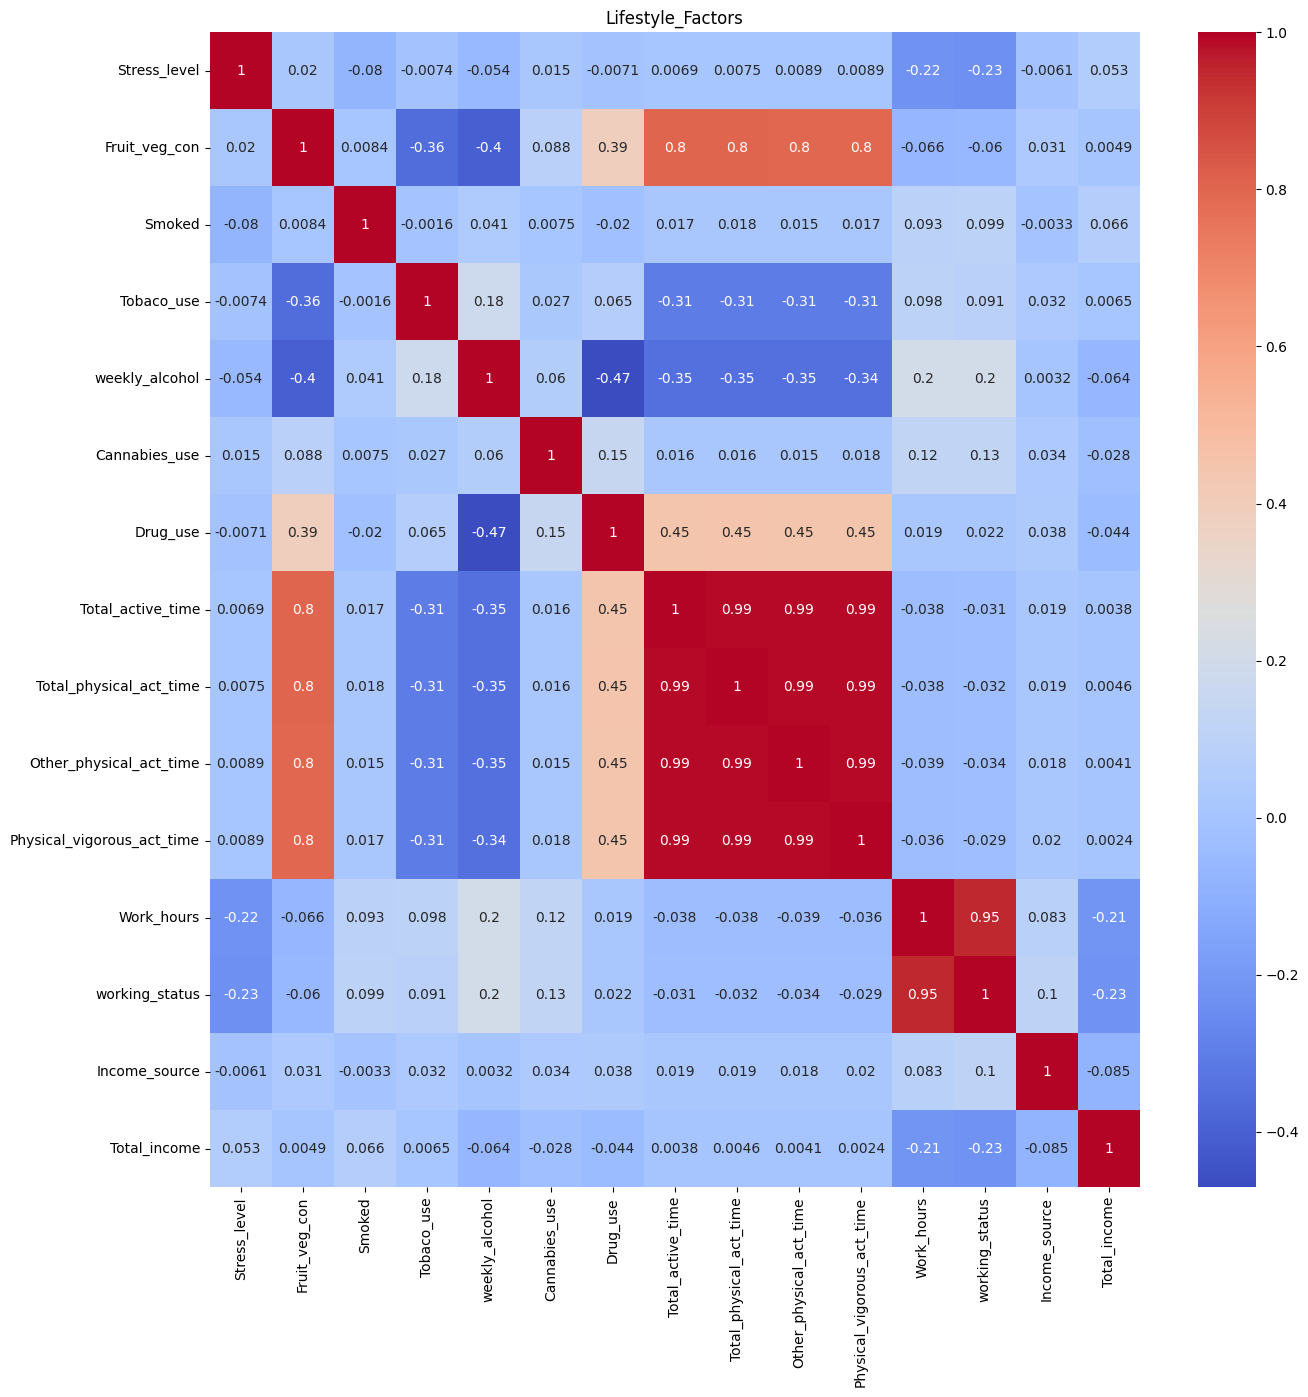

In [7]:
Lifestyle_Factors = ['Fruit_veg_con', 'Smoked', 'Tobaco_use', 'weekly_alcohol', 'Cannabies_use', 'Drug_use',
                     'Total_active_time', 'Total_physical_act_time', 'Other_physical_act_time','Physical_vigorous_act_time', 
                     'Work_hours', 'working_status', 
                     'Income_source', 'Total_income'
                                         
]

plt.figure(figsize=(15, 15))
plt.title('Lifestyle_Factors')
correlation_matrix = data[['Stress_level']+Lifestyle_Factors].corr() 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm') 

Уберем слишком корелирующие признаки о спорте. И думаю надо убрать факт (status) работы, потому что есть часы и нам надо поменьше категориальных признаков

In [8]:
to_drop = ['Total_active_time'	,'Total_physical_act_time',	'Other_physical_act_time', 'working_status']
data=data.drop(columns=to_drop)
Lifestyle_Factors = [item for item in Lifestyle_Factors if item not in to_drop]

<Axes: title={'center': 'Mental_Health_Conditions'}>

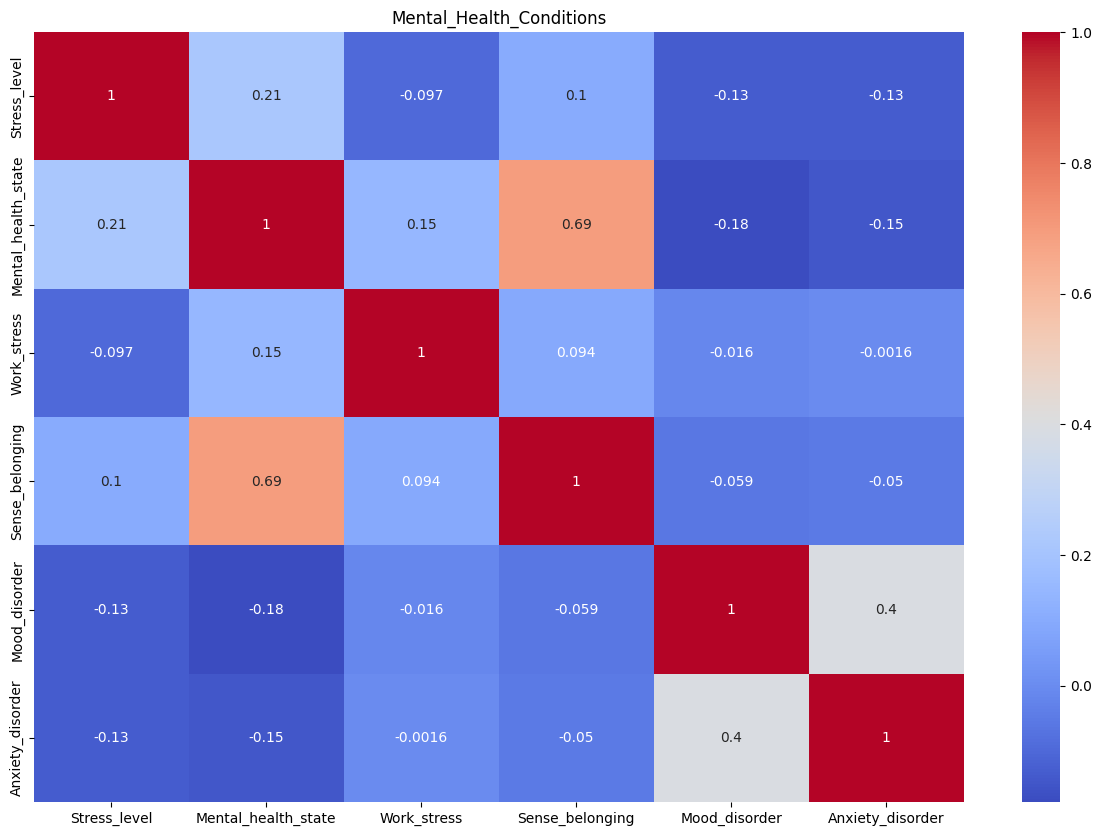

In [9]:
Mental_Health_Conditions = [
       'Mental_health_state', 'Work_stress', 'Sense_belonging','Mood_disorder', 'Anxiety_disorder',
]

plt.figure(figsize=(15, 10))
plt.title('Mental_Health_Conditions')
correlation_matrix = data[['Stress_level']+Mental_Health_Conditions].corr() 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm') 

<Axes: title={'center': 'Mental_Health_Conditions and Lifestyle_Factors'}>

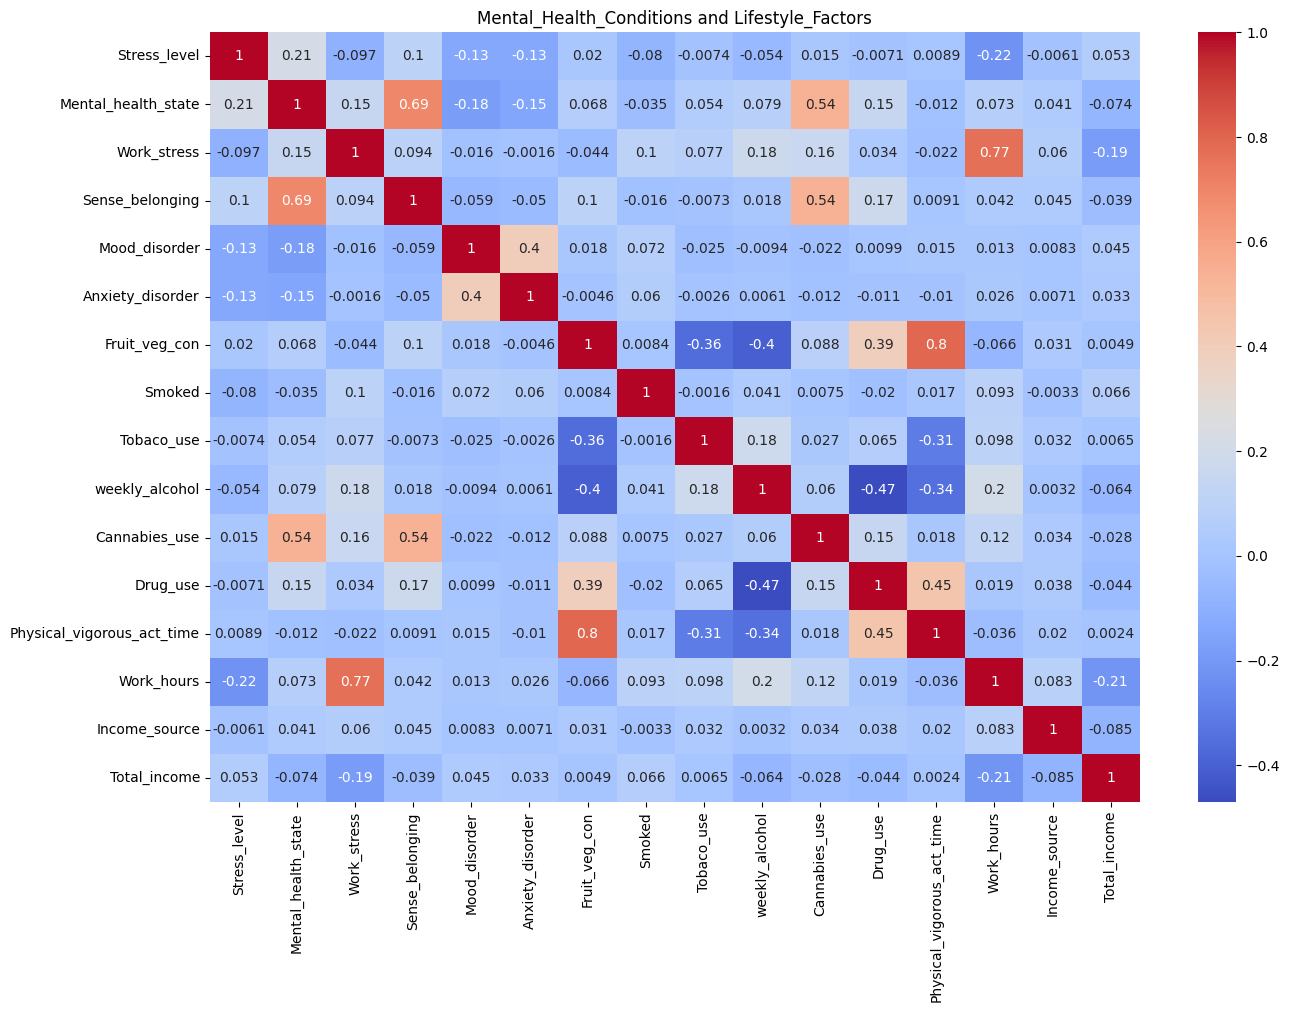

In [10]:
plt.figure(figsize=(15, 10))
plt.title('Mental_Health_Conditions and Lifestyle_Factors')
correlation_matrix = data[['Stress_level']+Mental_Health_Conditions+Lifestyle_Factors].corr() 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm') 

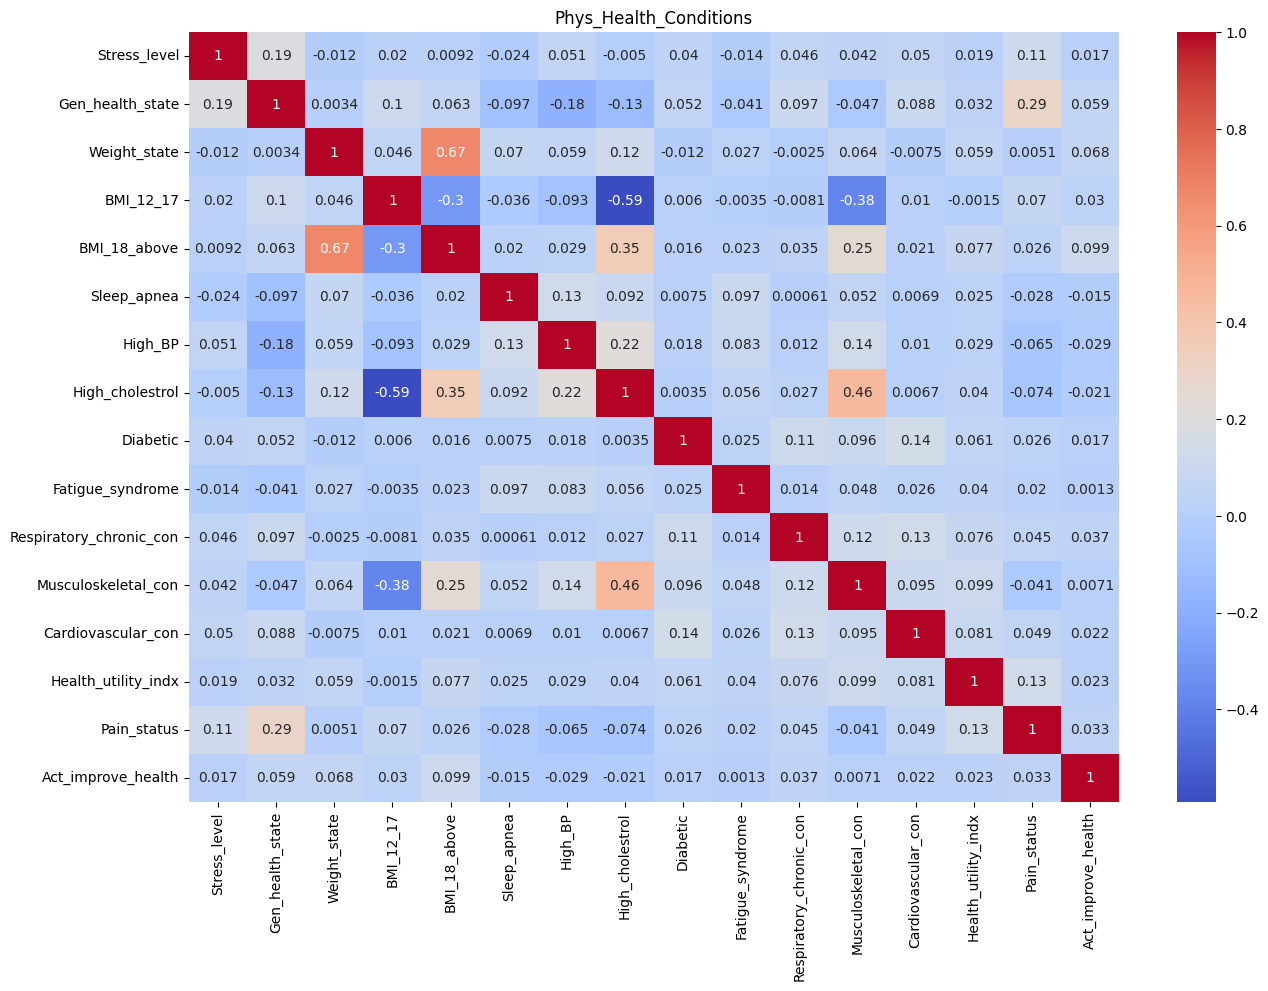

In [11]:
Phys_Health_Conditions = ['Gen_health_state', 'Weight_state', 'BMI_12_17', 'BMI_18_above', 'Sleep_apnea', 'High_BP',
       'High_cholestrol', 'Diabetic', 'Fatigue_syndrome',
        'Respiratory_chronic_con', 'Musculoskeletal_con',
       'Cardiovascular_con', 'Health_utility_indx', 'Pain_status',
       'Act_improve_health', ]
plt.figure(figsize=(15,10))
plt.title('Phys_Health_Conditions')
sns.heatmap(data[['Stress_level']+Phys_Health_Conditions].corr(), annot=True, cmap='coolwarm')
plt.show()

<Axes: title={'center': 'Phys_Health_Conditions + Mental_Health_Conditions'}>

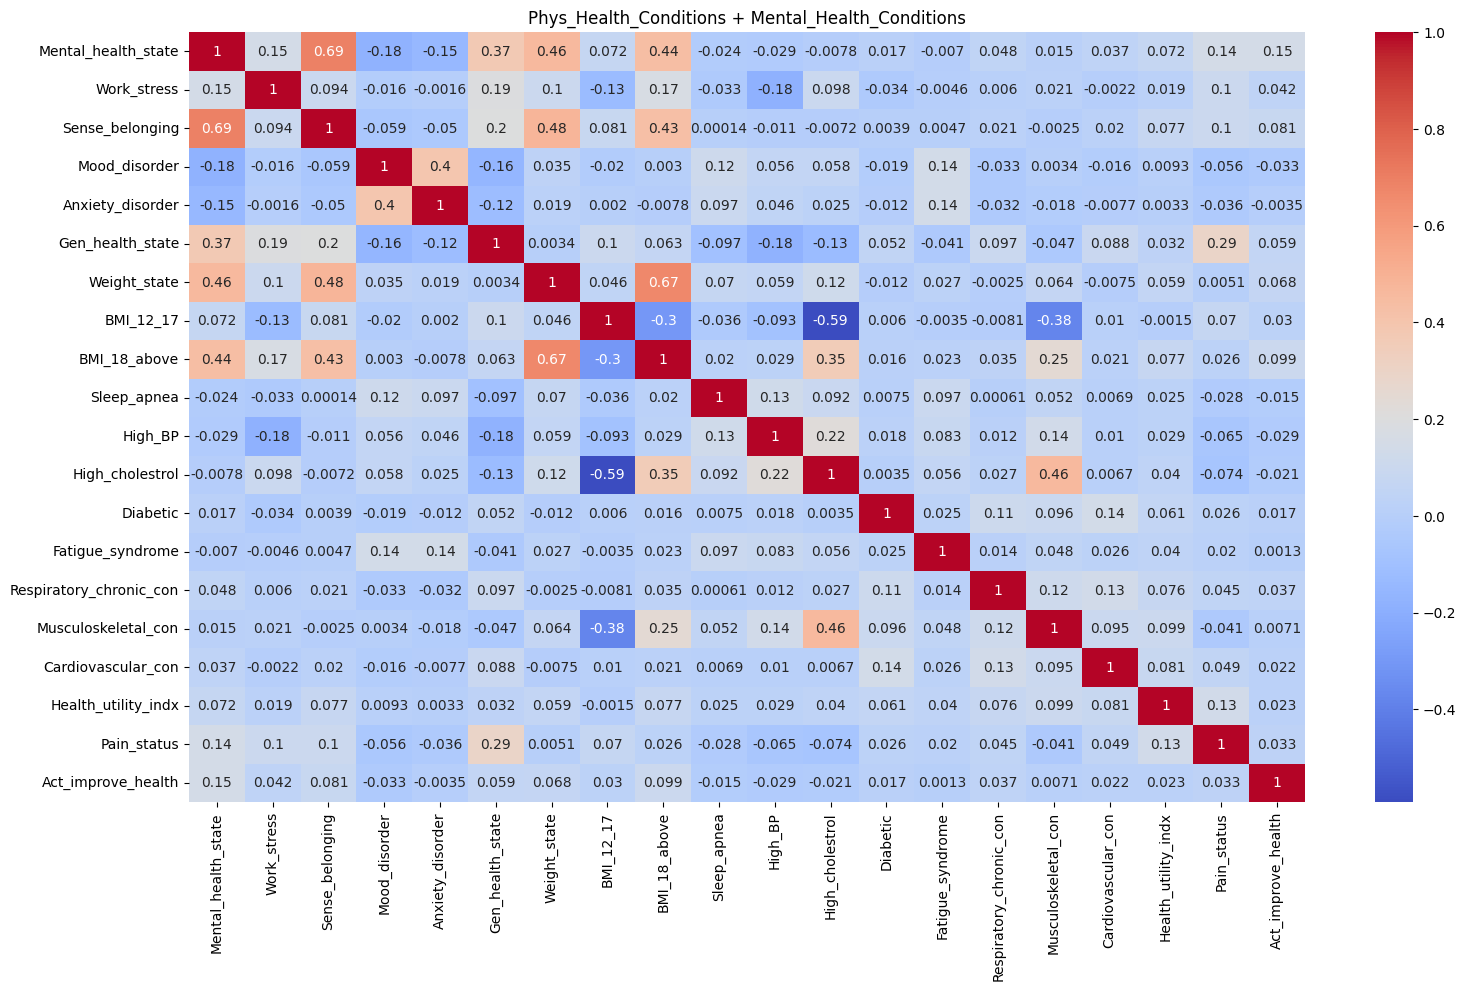

In [12]:
plt.figure(figsize=(18,10))
plt.title('Phys_Health_Conditions + Mental_Health_Conditions')
sns.heatmap(data[Mental_Health_Conditions+Phys_Health_Conditions].corr(), annot=True, cmap='coolwarm')

In [13]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(data)
# profile.to_notebook_iframe()


In [14]:
data.columns

Index(['Province', 'Gender', 'Marital_status', 'Household', 'Age',
       'Worked_job_business', 'Edu_level', 'Gen_health_state',
       'Life_satisfaction', 'Mental_health_state', 'Stress_level',
       'Work_stress', 'Sense_belonging', 'Weight_state', 'BMI_12_17',
       'BMI_18_above', 'Sleep_apnea', 'High_BP', 'High_cholestrol', 'Diabetic',
       'Fatigue_syndrome', 'Mood_disorder', 'Anxiety_disorder',
       'Respiratory_chronic_con', 'Musculoskeletal_con', 'Cardiovascular_con',
       'Health_utility_indx', 'Pain_status', 'Act_improve_health',
       'Fruit_veg_con', 'Smoked', 'Tobaco_use', 'weekly_alcohol',
       'Cannabies_use', 'Drug_use', 'Physical_vigorous_act_time', 'Work_hours',
       'Aboriginal_identity', 'Birth_country', 'Immigrant', 'Insurance_cover',
       'Food_security', 'Income_source', 'Total_income'],
      dtype='object')

In [15]:
for col in data.columns:
    print(col, data[col].unique())

Province [47 59 13 46 35 12 24 10 48 11 60]
Gender [2 1]
Marital_status [1 2 6 9]
Household [2 1 9]
Age [3 5 4 2 1]
Worked_job_business [1 6 2 9 8 7]
Edu_level [3 2 1 9]
Gen_health_state [3 2 5 1 4 7 8]
Life_satisfaction [ 9  4  7  8  0 10  6  5 99  3  2 97 98  1]
Mental_health_state [3 5 2 1 4 9 7 8]
Stress_level [2 3 4 1 5 7 8]
Work_stress [2 6 4 3 7 1 5 9 8]
Sense_belonging [2 3 1 4 9 7 8]
Weight_state [3 1 9 2 6 7 8]
BMI_12_17 [6 1 9 2]
BMI_18_above [2 1 6 9]
Sleep_apnea [2 1 7 8]
High_BP [2 1 7 8]
High_cholestrol [2 1 6 7 8]
Diabetic [2 1 9 7 8]
Fatigue_syndrome [2 1 7 8]
Mood_disorder [2 1 7 8]
Anxiety_disorder [2 1 7 8]
Respiratory_chronic_con [2 1 9]
Musculoskeletal_con [2 1 6 9]
Cardiovascular_con [2 9 1]
Health_utility_indx [1 9 2]
Pain_status [2 1 9]
Act_improve_health [6 2 1 9 7 8]
Fruit_veg_con [1.3000e+00 1.0000e+00 9.9996e+03 7.3000e+00 4.4000e+00 2.8000e+00
 0.0000e+00 6.4000e+00 3.0000e+00 2.7000e+00 3.1000e+00 8.0000e+00
 1.9000e+00 8.9000e+00 2.9000e+00 2.4000e+00 3.

In [16]:
data

,Province,Gender,Marital_status,Household,Age,Worked_job_business,Edu_level,Gen_health_state,Life_satisfaction,Mental_health_state,Stress_level,Work_stress,Sense_belonging,Weight_state,BMI_12_17,BMI_18_above,Sleep_apnea,High_BP,High_cholestrol,Diabetic,Fatigue_syndrome,Mood_disorder,Anxiety_disorder,Respiratory_chronic_con,Musculoskeletal_con,Cardiovascular_con,Health_utility_indx,Pain_status,Act_improve_health,Fruit_veg_con,Smoked,Tobaco_use,weekly_alcohol,Cannabies_use,Drug_use,Physical_vigorous_act_time,Work_hours,Aboriginal_identity,Birth_country,Immigrant,Insurance_cover,Food_security,Income_source,Total_income
0,47,2,1,2,3,1,3,3,9,3,2,2,2,3,6,2,2,2,2,2,2,2,2,2,2,2,1,2,6,1.3,996.0,6,996,2,2,10,38,2,1,2,1,0,1,5
1,47,1,1,2,5,6,2,3,4,3,3,6,3,1,6,2,1,1,2,2,2,1,2,2,2,2,9,1,6,1.0,996.0,6,996,2,2,0,96,2,1,2,1,0,2,4
2,59,2,2,1,5,6,1,2,7,3,3,6,2,1,6,2,2,1,2,1,2,2,2,1,1,2,1,1,6,9999.6,996.0,2,996,2,2,9996,96,2,1,2,6,6,2,2
3,13,1,2,1,5,6,1,3,8,3,3,6,2,1,6,2,2,1,2,2,2,2,2,2,1,2,2,1,6,9999.6,996.0,6,996,2,6,9996,96,2,1,2,6,0,2,3
4,46,1,2,1,4,2,3,5,0,5,4,6,3,3,6,2,2,1,2,9,2,2,2,9,1,9,1,2,6,9999.6,996.0,6,996,2,2,9996,96,2,1,2,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108247,11,2,1,2,5,6,1,2,9,2,2,6,3,1,6,2,2,1,1,2,2,2,2,2,1,2,2,1,2,3.3,8.0,6,996,2,6,0,96,2,1,2,6,0,2,2
108248,35,2,2,2,2,1,3,3,5,4,4,2,2,2,6,1,2,2,2,2,2,1,2,2,2,2,2,1,6,9999.6,996.0,6,6,1,6,9996,30,2,1,2,6,1,1,4
108249,13,1,2,2,2,1,3,1,9,3,3,3,2,2,6,1,2,2,2,2,2,2,2,2,2,2,1,1,6,9999.6,996.0,6,996,1,6,9996,96,2,1,2,6,0,9,2
108250,59,1,1,2,5,6,2,3,8,2,2,6,2,1,6,2,2,2,1,2,2,2,2,2,2,2,2,1,6,9999.6,996.0,2,996,2,2,9996,96,2,1,2,6,6,2,5


значения во всяуиз болезнях: 

1	Да — болен

2	Нет — не болен

7	Неизвестно / Не помнит

8	Отказ от ответа

9	Не применимо (например, младенец / не спрашивали)

In [24]:
def decoder(code):
    if code == 1:
        return 1 # да
    if code == 2:
        return 0 # нет
    else: 
        return 2 # неизвестно

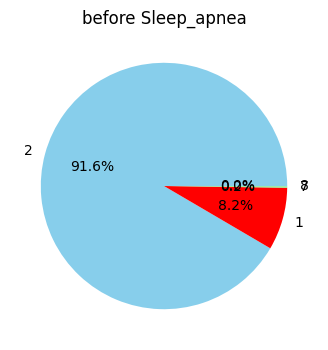

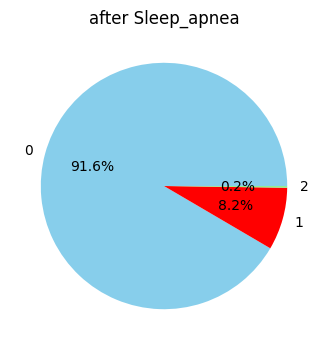

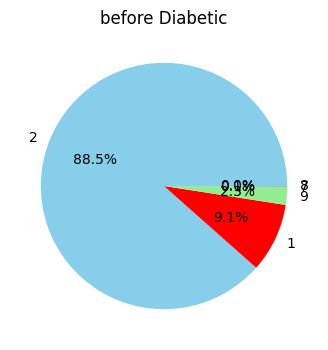

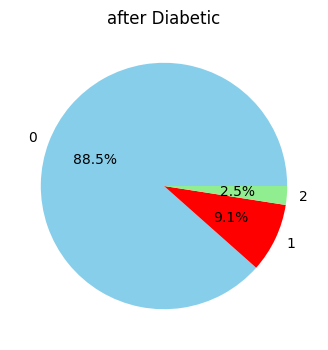

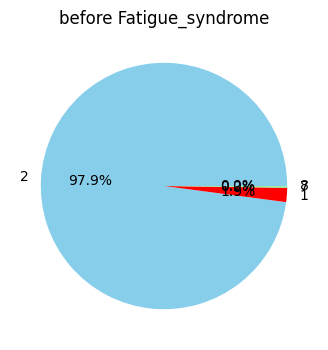

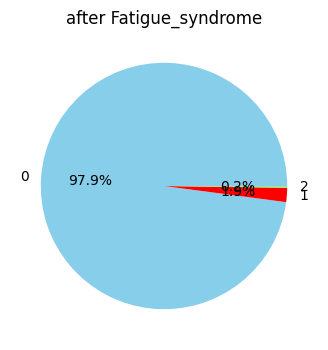

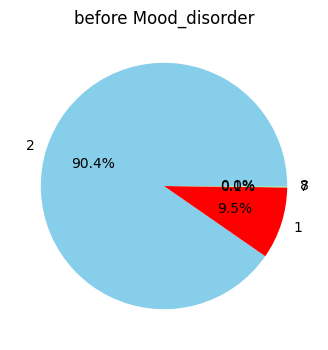

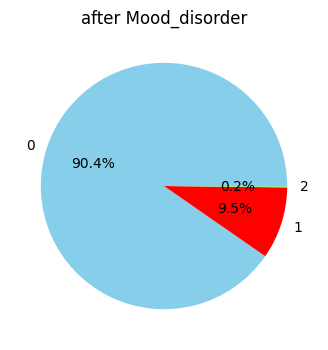

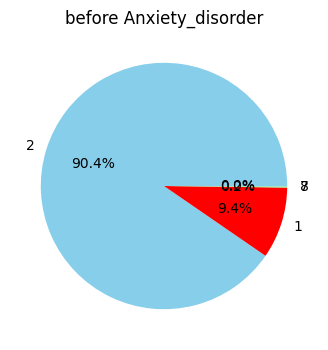

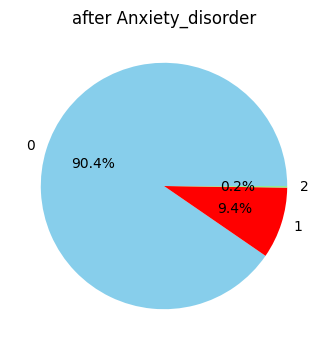

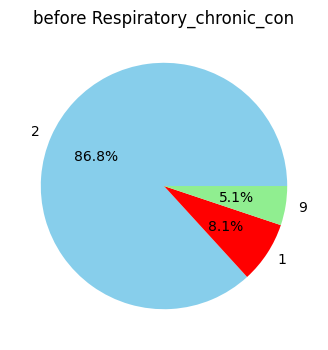

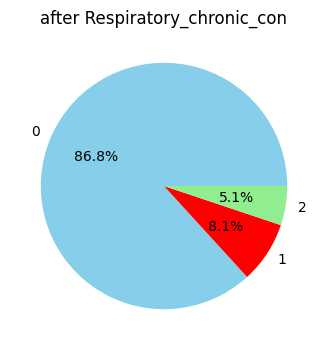

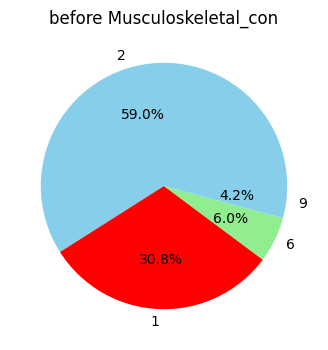

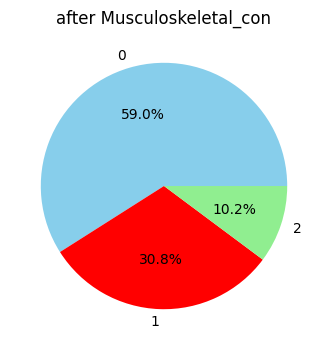

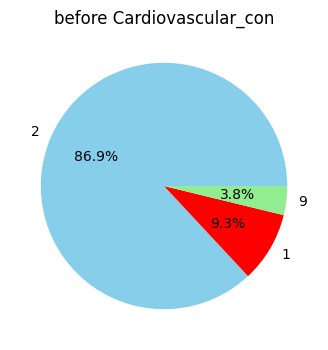

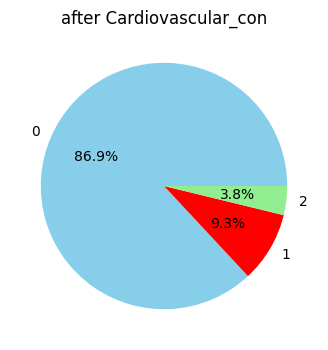

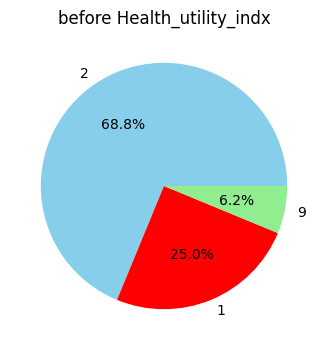

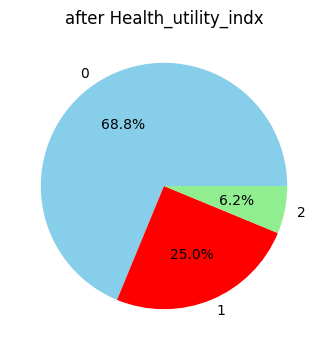

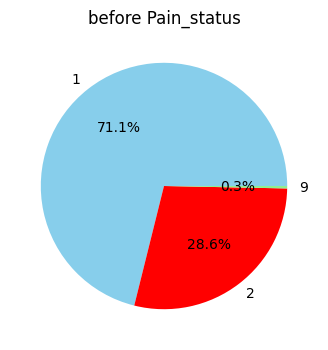

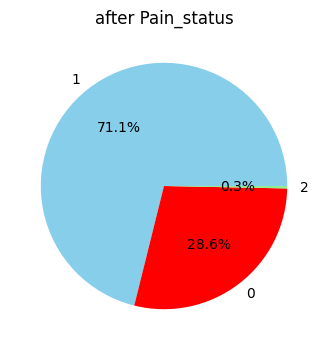

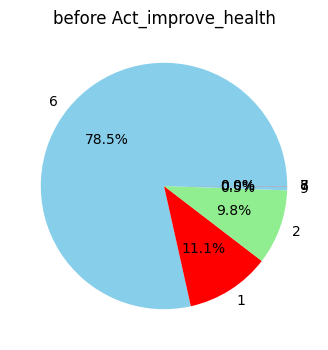

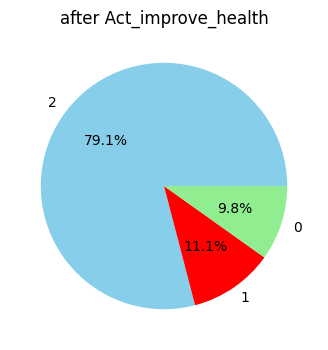

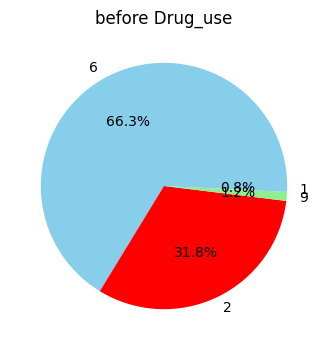

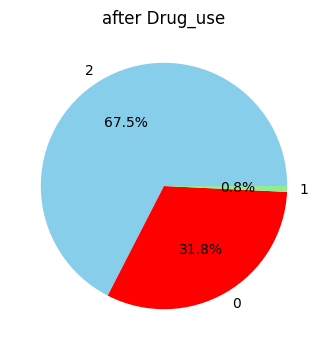

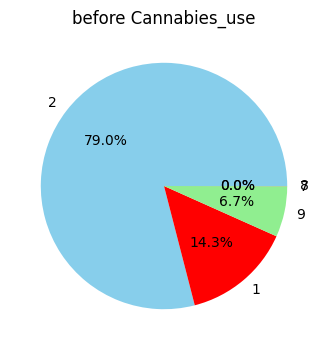

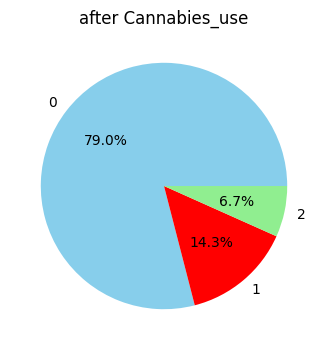

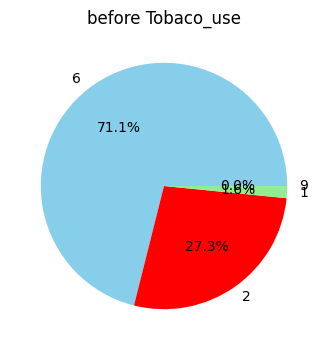

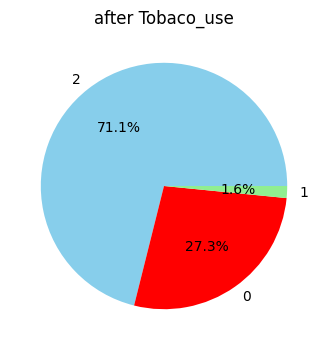

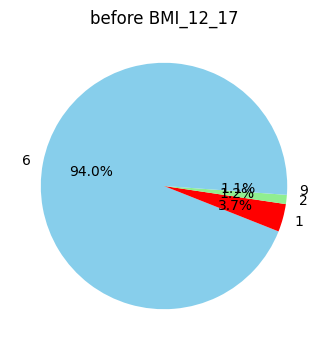

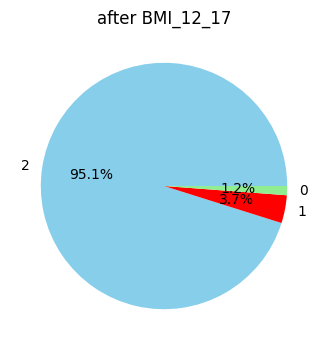

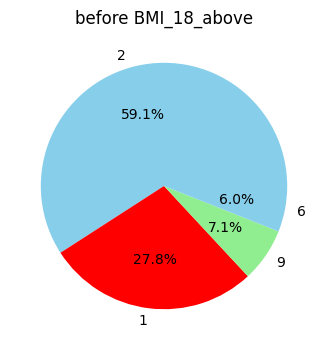

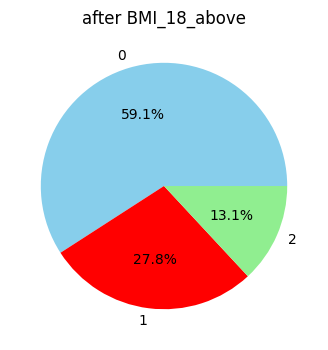

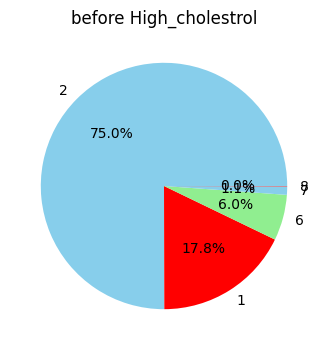

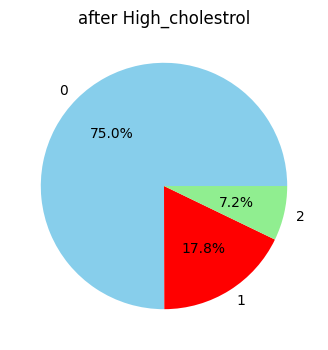

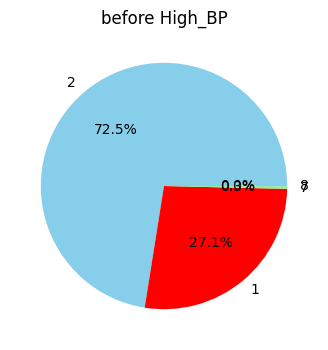

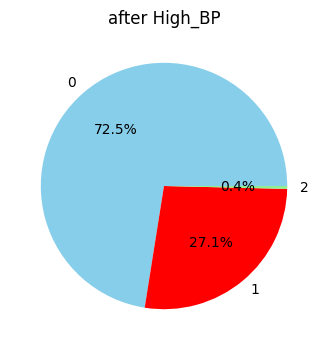

In [25]:
for_decoding = [
    'Sleep_apnea', 
    'Diabetic', 
    'Fatigue_syndrome', 
    'Mood_disorder', 
    'Anxiety_disorder', 
    'Respiratory_chronic_con',
    'Musculoskeletal_con', 
    'Cardiovascular_con', 
    'Health_utility_indx',
    'Pain_status',
    'Act_improve_health',
    'Drug_use',
    'Cannabies_use',
    'Tobaco_use',
    'BMI_12_17', 
    'BMI_18_above',

    'High_cholestrol',
    'High_BP',

    
]
data0=data.copy()
for col in for_decoding:
    class_counts_before = pd.Series(data[col]).value_counts()
    data[col] = data[col].apply(decoder)
    class_counts_after = pd.Series(data[col]).value_counts()   
    
    plt.figure(figsize=(4, 4))
    plt.title(f'before {col}')
    plt.pie(class_counts_before, labels=class_counts_before.index, autopct='%1.1f%%', colors=['skyblue', 'red', 'lightgreen'])
    plt.show()

    plt.figure(figsize=(4, 4))
    plt.title(f'after {col}')
    plt.pie(class_counts_after, labels=class_counts_after.index, autopct='%1.1f%%', colors=['skyblue', 'red', 'lightgreen'])
    plt.show()



In [26]:
data

,Province,Gender,Marital_status,Household,Age,Worked_job_business,Edu_level,Gen_health_state,Life_satisfaction,Mental_health_state,Stress_level,Work_stress,Sense_belonging,Weight_state,BMI_12_17,BMI_18_above,Sleep_apnea,High_BP,High_cholestrol,Diabetic,Fatigue_syndrome,Mood_disorder,Anxiety_disorder,Respiratory_chronic_con,Musculoskeletal_con,Cardiovascular_con,Health_utility_indx,Pain_status,Act_improve_health,Fruit_veg_con,Smoked,Tobaco_use,weekly_alcohol,Cannabies_use,Drug_use,Physical_vigorous_act_time,Work_hours,Aboriginal_identity,Birth_country,Immigrant,Insurance_cover,Food_security,Income_source,Total_income
0,47,2,1,2,3,1,3,3,9,3,2,2,2,3,2,0,0,0,0,0,0,0,0,0,0,0,1,0,2,1.3,996.0,2,996,0,0,10,38,2,1,2,1,0,1,5
1,47,1,1,2,5,6,2,3,4,3,3,6,3,1,2,0,1,1,0,0,0,1,0,0,0,0,2,1,2,1.0,996.0,2,996,0,0,0,96,2,1,2,1,0,2,4
2,59,2,2,1,5,6,1,2,7,3,3,6,2,1,2,0,0,1,0,1,0,0,0,1,1,0,1,1,2,9999.6,996.0,0,996,0,0,9996,96,2,1,2,6,6,2,2
3,13,1,2,1,5,6,1,3,8,3,3,6,2,1,2,0,0,1,0,0,0,0,0,0,1,0,0,1,2,9999.6,996.0,2,996,0,2,9996,96,2,1,2,6,0,2,3
4,46,1,2,1,4,2,3,5,0,5,4,6,3,3,2,0,0,1,0,2,0,0,0,2,1,2,1,0,2,9999.6,996.0,2,996,0,0,9996,96,2,1,2,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108247,11,2,1,2,5,6,1,2,9,2,2,6,3,1,2,0,0,1,1,0,0,0,0,0,1,0,0,1,0,3.3,8.0,2,996,0,2,0,96,2,1,2,6,0,2,2
108248,35,2,2,2,2,1,3,3,5,4,4,2,2,2,2,1,0,0,0,0,0,1,0,0,0,0,0,1,2,9999.6,996.0,2,6,1,2,9996,30,2,1,2,6,1,1,4
108249,13,1,2,2,2,1,3,1,9,3,3,3,2,2,2,1,0,0,0,0,0,0,0,0,0,0,1,1,2,9999.6,996.0,2,996,1,2,9996,96,2,1,2,6,0,9,2
108250,59,1,1,2,5,6,2,3,8,2,2,6,2,1,2,0,0,0,1,0,0,0,0,0,0,0,0,1,2,9999.6,996.0,0,996,0,0,9996,96,2,1,2,6,6,2,5


# всё должно быть категориями!

Возможно пришло время не категориальные данные надо сделать категориальными, хотя это возможно немного замедлит работу классификатора

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


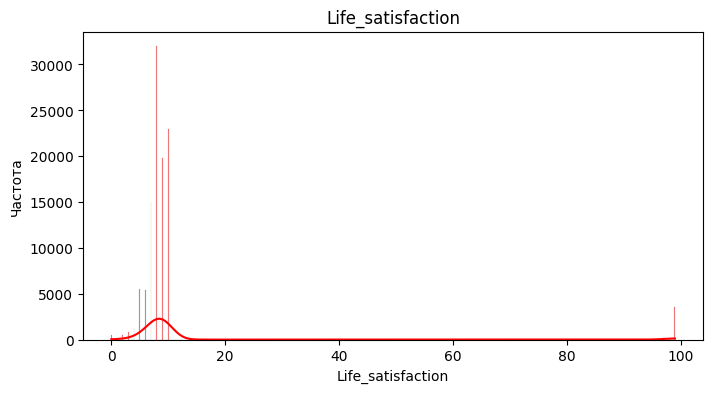

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


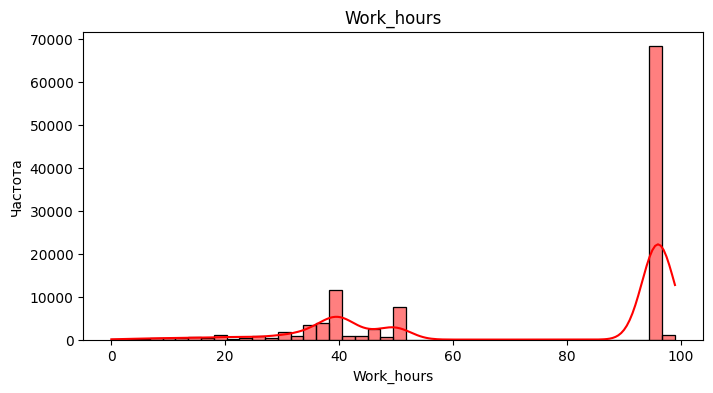

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


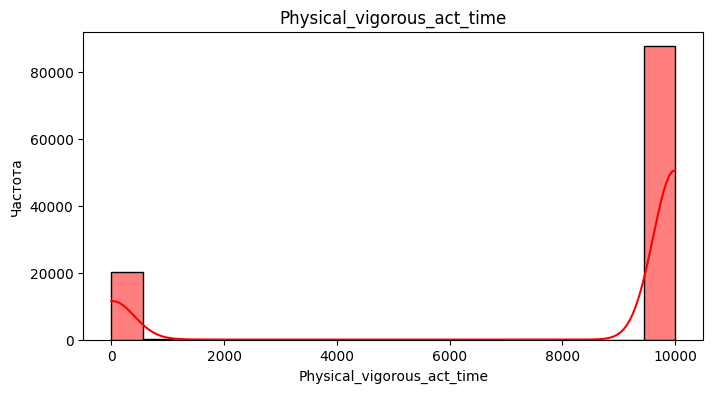

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


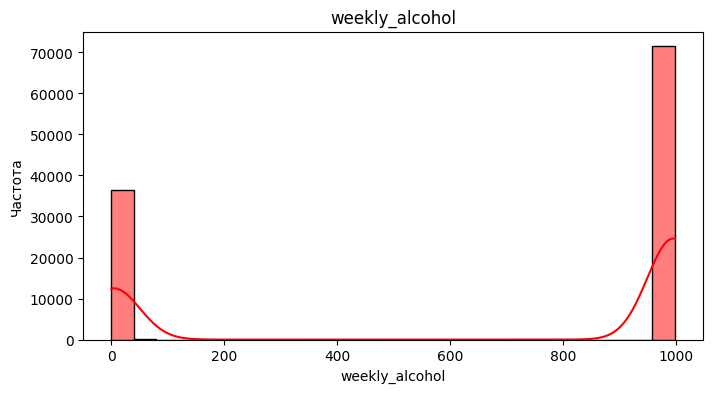

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


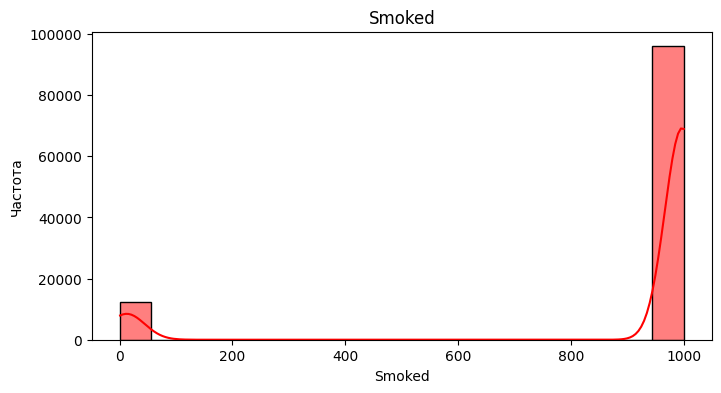

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


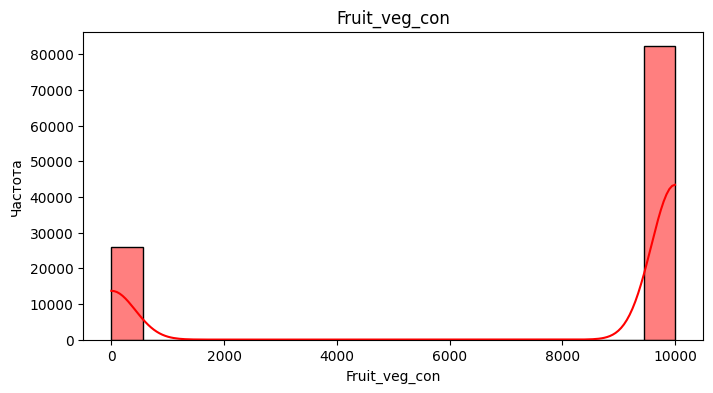

In [27]:
to_cat = [
    'Life_satisfaction',
    'Work_hours',
    'Physical_vigorous_act_time',
    'weekly_alcohol',
    'Smoked',
    'Fruit_veg_con']

for column in to_cat:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[column], kde=True, color='red')
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

возмьём и в тупую посчитаем количество столбиков, столько и будет категорий. Но здесь к сожалению не работает автоматическое разбиаение и-за дупликатов, поэтому ручками:

In [28]:
def bin_life_satisfaction(val):
    if val in [97, 98, 99]:
        return 5  # Особая категория
    elif val <= 2:
        return 0
    elif val <= 4:
        return 1
    elif val <= 6:
        return 2
    elif val <= 8:
        return 3
    else:
        return 4

def bin_work_hours(val):
    if val == 99:
        return 4
    elif val <= 15:
        return 0
    elif val <= 35:
        return 1
    elif val <= 45:
        return 2
    elif val <= 60:
        return 3
    else:
        return 4

def bin_physical_vigorous(val):
    if val in [9996, 9997, 9998, 9999]:
        return 2
    elif val <= 30:
        return 0
    elif val <= 180:
        return 1
    else:
        return 2

def bin_weekly_alcohol(val):
    if val in [996, 999]:
        return 2
    elif val <= 5:
        return 0
    elif val <= 20:
        return 1
    else:
        return 2

def bin_smoked(val):
    if val in [996, 999]:
        return 2
    elif val <= 10:
        return 0
    else:
        return 1

def bin_fruit_veg_con(val):
    if val in [9999.6, 9999.9]:
        return 2
    elif val < 3:
        return 0
    else:
        return 1


data['Life_satisfaction'] = data['Life_satisfaction'].apply(bin_life_satisfaction)
data['Work_hours'] = data['Work_hours'].apply(bin_work_hours)
data['Physical_vigorous_act_time'] = data['Physical_vigorous_act_time'].apply(bin_physical_vigorous)
data['weekly_alcohol'] = data['weekly_alcohol'].apply(bin_weekly_alcohol)
data['Smoked'] = data['Smoked'].apply(bin_smoked)
data['Fruit_veg_con'] = data['Fruit_veg_con'].apply(bin_fruit_veg_con)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


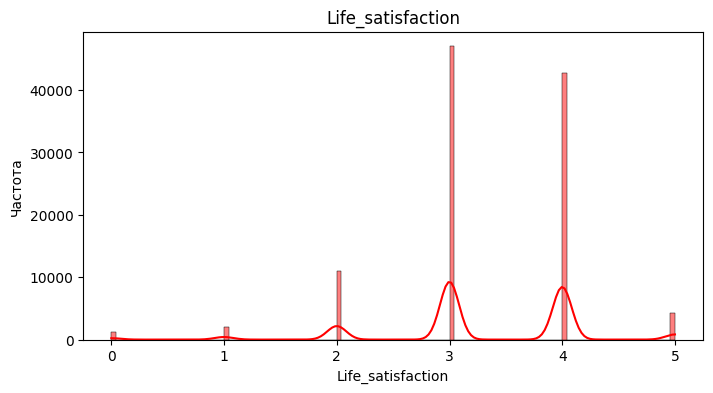

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


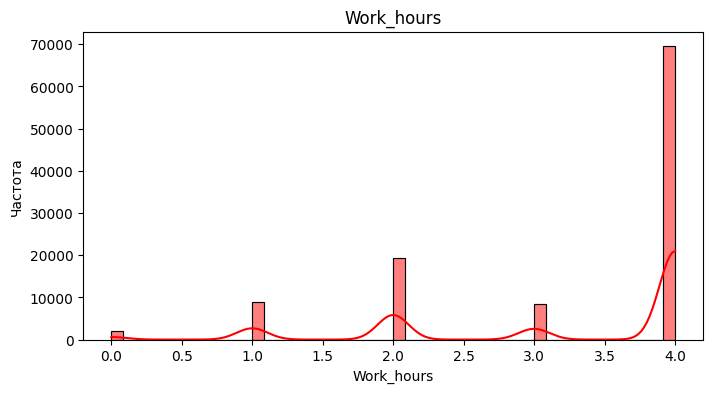

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


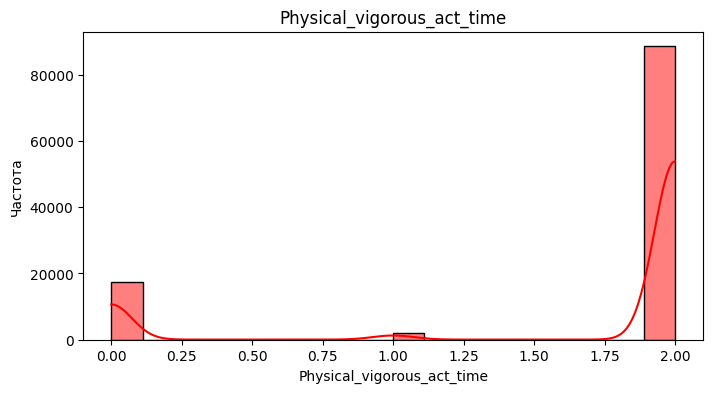

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


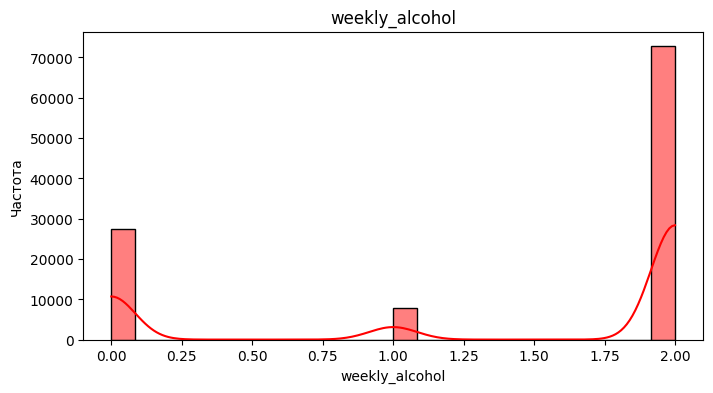

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


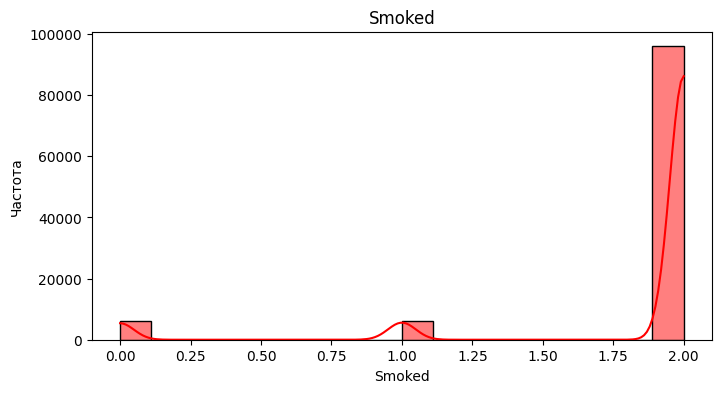

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


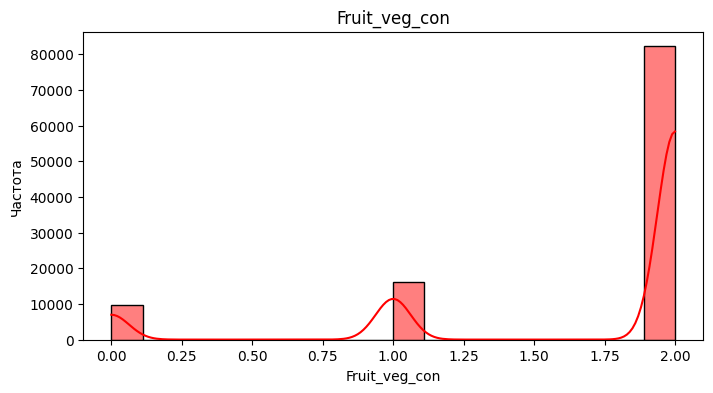

In [29]:
for column in to_cat:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[column], kde=True, color='red')
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

Сойдёт, разбиения на предсказания негативно не влияют

# стат гипотезы 🧠

**p-value** — это вероятность того, что мы получим результат не хуже наблюдаемого, если нулевая гипотеза верна

Выдвигаем нулевую гипотезу (H₀)

Вычисляем p-value

И решаем: отвергнуть или не отвергать H₀


**p-value	Интерпретация**
* ≤ 0.01	📛 Очень сильные доказательства против H₀ (разница значимая)
* ≤ 0.05	⚠️ Есть основания отвергнуть H₀ (обычный порог значимости)
*  _ > 0.05	✅ Недостаточно оснований отвергнуть H₀ (разница может быть случайной)


H0 - наши данные (возмьём пока что с важностью >2) НЕ влияют на уровень стресса и все совпадения случайны, H1 - они влияют
aka мы просто хотим доказать, что все эти корреляции не случайны

In [30]:
# на данный момент топ выглядит так (придётся поверить на слова)
top = ['Work_stress',
 'Life_satisfaction',
 'Mental_health_state',
 'Sense_belonging',
 'Age',
 'Gen_health_state',
 'Province',
 'Income_source',
 # 'BMI_real',
 'Work_hours',
 'Edu_level',
 'Health_utility_indx',
 'Anxiety_disorder',
 'Food_security',
 'Total_income',
 'Gender']

**ttest_ind** — это t-тест Стьюдента для независимых выборок, и он отвечает на вопрос:

**❓ Есть ли статистически значимая разница между средними двух независимых групп?**

Берём именно эти тесты, потому что у нас не нормальное распределение

1 2
T-статистика: -17.4339
p-value: 0.0000
1 3
T-статистика: -45.0266
p-value: 0.0000
1 4
T-статистика: -72.2883
p-value: 0.0000
1 5
T-статистика: -59.1110
p-value: 0.0000
1 6
T-статистика: -16.5951
p-value: 0.0000
1 7
T-статистика: -7.1244
p-value: 0.0000
1 8
T-статистика: -4.2534
p-value: 0.0005
1 9
T-статистика: -27.5829
p-value: 0.0000
2 1
T-статистика: 17.4339
p-value: 0.0000
2 3
T-статистика: -44.3701
p-value: 0.0000
2 4
T-статистика: -84.7409
p-value: 0.0000
2 5
T-статистика: -54.7751
p-value: 0.0000
2 6
T-статистика: 4.5204
p-value: 0.0000
2 7
T-статистика: -5.5010
p-value: 0.0000
2 8
T-статистика: -3.6680
p-value: 0.0018
2 9
T-статистика: -20.0353
p-value: 0.0000
3 1
T-статистика: 45.0266
p-value: 0.0000
3 2
T-статистика: 44.3701
p-value: 0.0000
3 4
T-статистика: -57.2572
p-value: 0.0000
3 5
T-статистика: -37.7136
p-value: 0.0000
3 6
T-статистика: 74.5752
p-value: 0.0000
3 7
T-статистика: -3.2136
p-value: 0.0018
3 8
T-статистика: -2.8497
p-value: 0.0106
3 9
T-статистика: -6.28

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


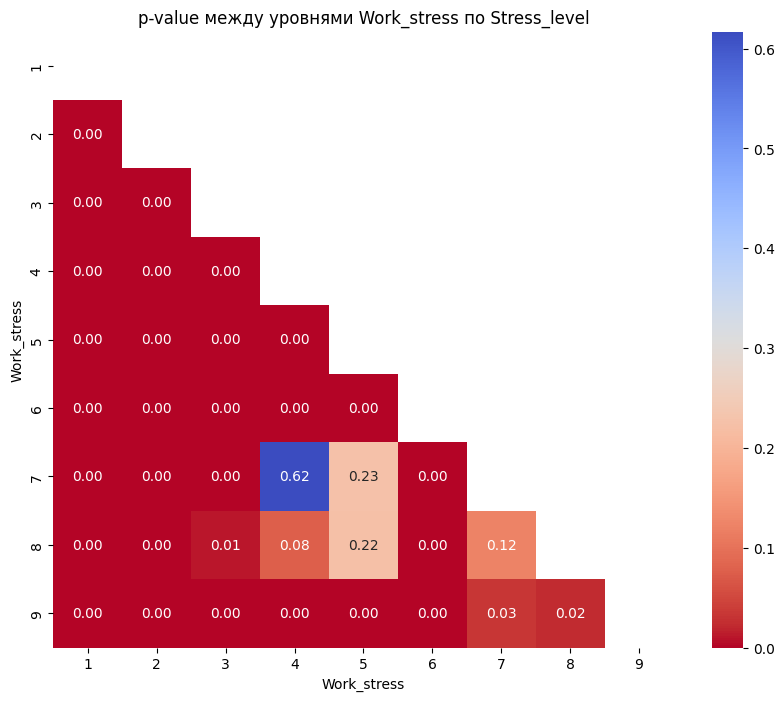

In [31]:
groups = sorted(data['Work_stress'].dropna().unique())
Series = {i: data[data['Work_stress'] == i]['Stress_level'].dropna() for i in groups}

p_matrix = pd.DataFrame(index=groups, columns=groups, dtype=float)

for i in groups:
    for j in groups:
        if i == j:
            p_matrix.loc[i, j] = np.nan
        else:
            t_stat, p_val = ttest_ind(Series[i], Series[j], nan_policy='omit', equal_var=False)
            p_matrix.loc[i, j] = p_val
            print(i, j)
            print(f"T-статистика: {t_stat:.4f}")
            print(f"p-value: {p_val:.4f}")

# Построим тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(p_matrix.astype(float), annot=True, fmt=".2f", cmap='coolwarm_r', mask=np.triu(np.ones_like(p_matrix, dtype=bool)))
plt.title('p-value между уровнями Work_stress по Stress_level')
plt.xlabel('Work_stress')
plt.ylabel('Work_stress')
plt.show()


Итак, итоговый вид выглядит достаточно прилично и гпт даже сделал эту прекрасную визуализацию. Так какой вывод? Разница в группах большая и не случайная, значит верна гипотеза H1 - верна. Но возможно количство групп стоит уменьшить (потому что средние значения, как-то не сильно между собой отличаются) 

проверим ещё другие:

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


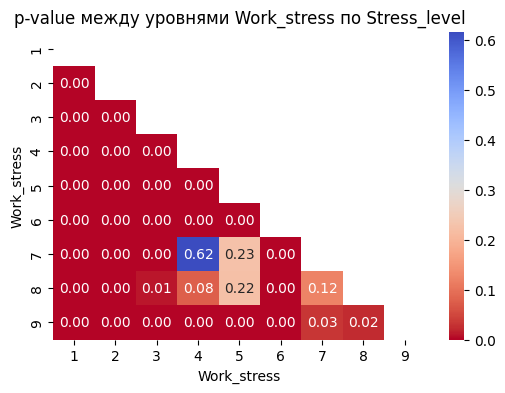

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


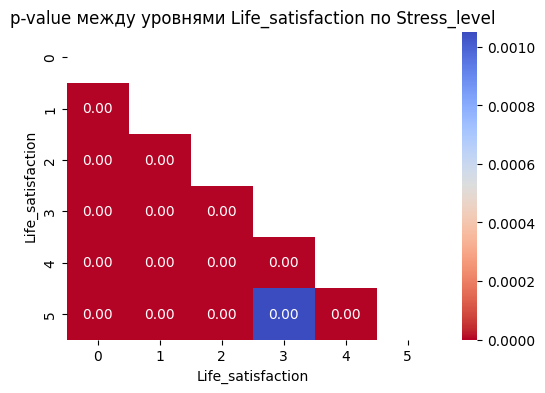

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


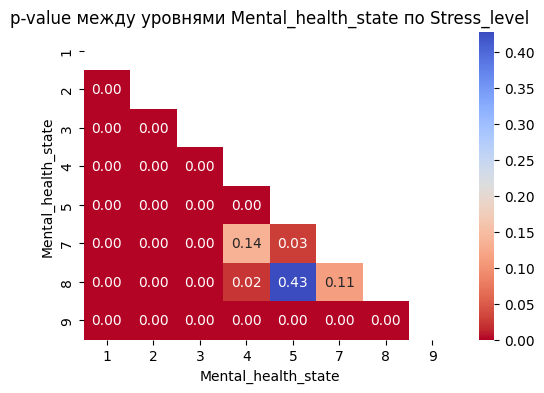

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


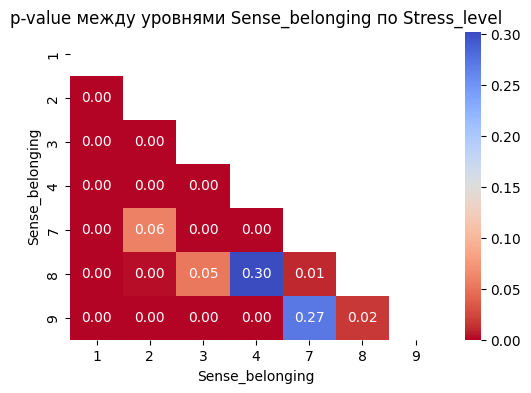

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


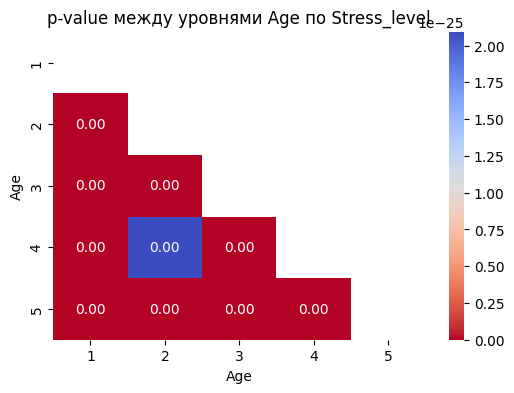

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


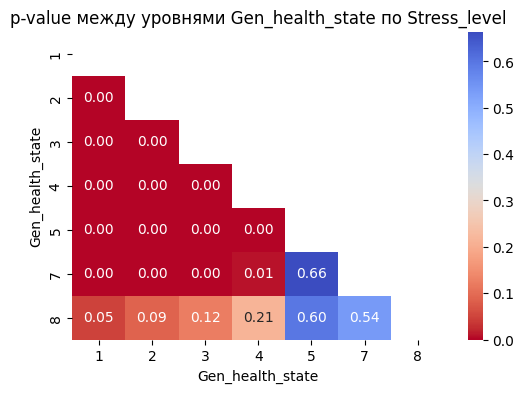

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


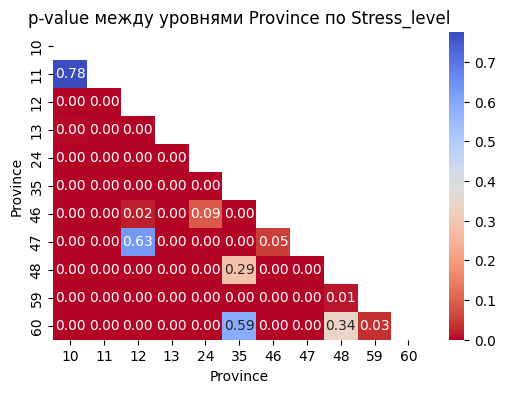

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


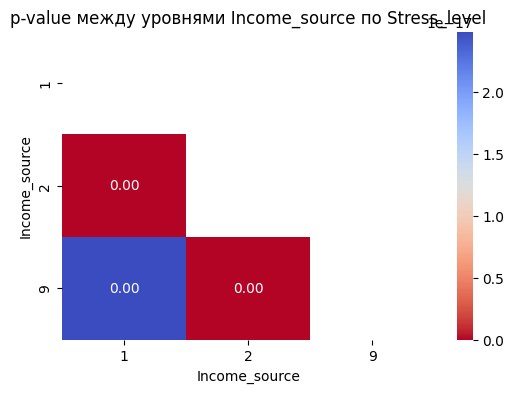

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


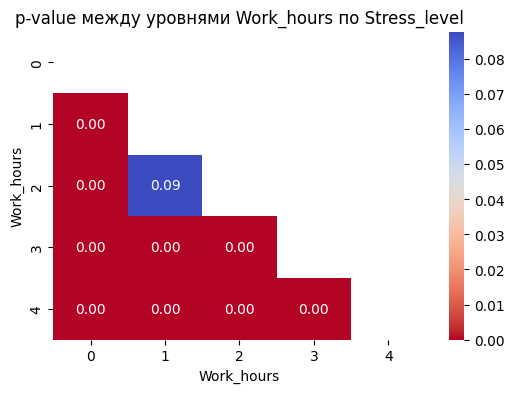

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


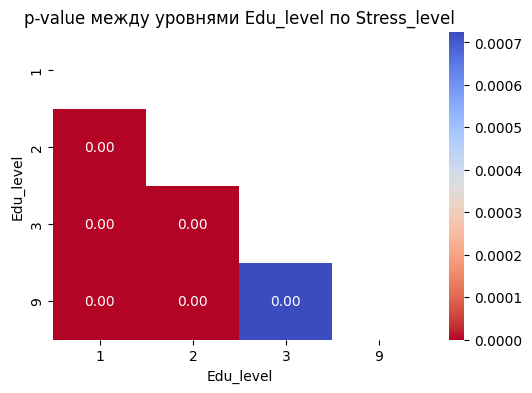

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


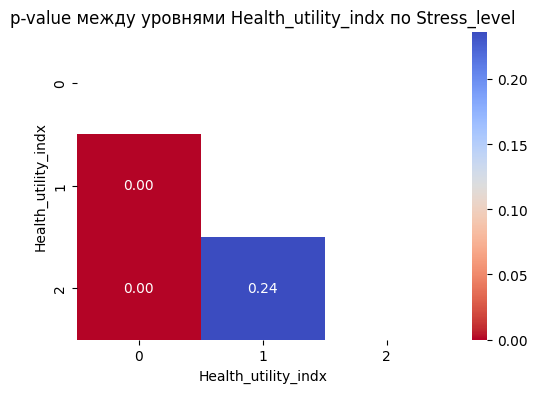

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


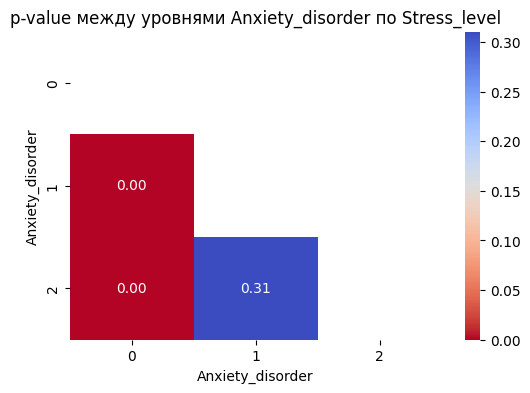

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


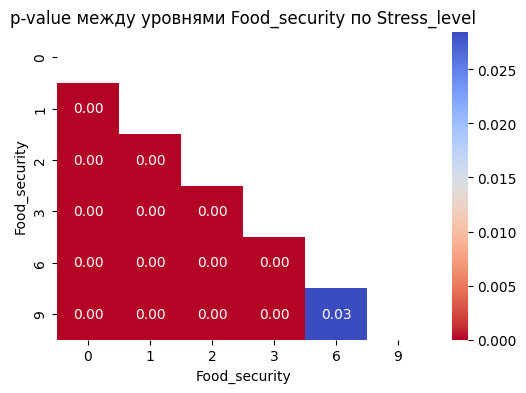

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


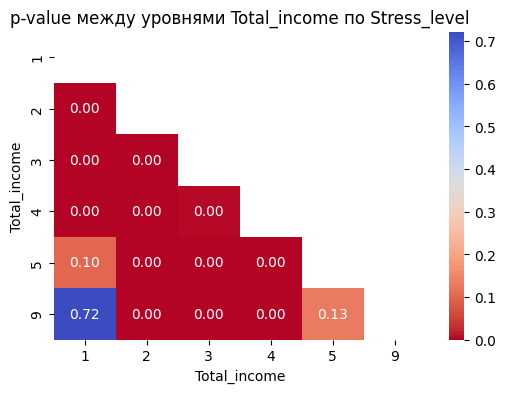

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


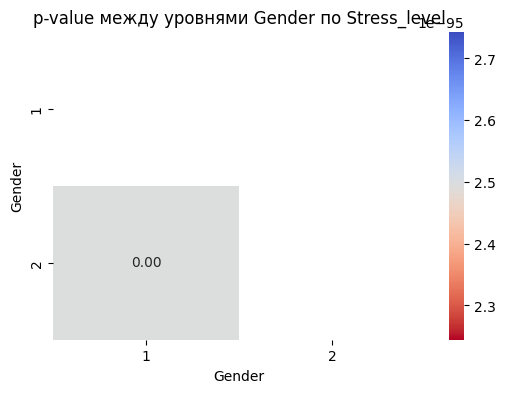

In [32]:
# top = [x for x in top if len(data[x].unique())<=10]
# ['Work_stress', 'Mental_health_state', 'Sense_belonging', 'Gen_health_state', 'Income_source', 'Edu_level', 'Health_utility_indx', 'Anxiety_disorder', 'Food_security', 'Total_income', 'Gender']

for feature in top:
    groups = sorted(data[feature].dropna().unique())
    Series = {i: data[data[feature] == i]['Stress_level'].dropna() for i in groups}
    
    p_matrix = pd.DataFrame(index=groups, columns=groups, dtype=float)
    
    for i in groups:
        for j in groups:
            if i == j:
                p_matrix.loc[i, j] = np.nan
            else:
                t_stat, p_val = ttest_ind(Series[i], Series[j], nan_policy='omit', equal_var=False)
                p_matrix.loc[i, j] = p_val
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(p_matrix.astype(float), annot=True, fmt=".2f", cmap='coolwarm_r', mask=np.triu(np.ones_like(p_matrix, dtype=bool)))
    plt.title(f'p-value между уровнями {feature} по Stress_level')
    plt.xlabel(f'{feature}')
    plt.ylabel(f'{feature}')
    plt.show()


немного уменьшим количество признаков

In [33]:
def simplify_decoder(x):
    if x in [1, 2]: return 0 #'Низкий'
    if x in [3]: return 1 #'Средний'
    if x in [4, 5, 6]: return 2 #'Высокий'
    if x in [7, 8, 9]: return 3 #'Неопределённый'

data['Work_stress'] = data['Work_stress'].apply(simplify_decoder)
data['Mental_health_state'] = data['Mental_health_state'].apply(simplify_decoder)
data['Sense_belonging'] = data['Sense_belonging'].apply(simplify_decoder)
data['Gen_health_state'] = data['Gen_health_state'].apply(simplify_decoder)
data['Total_income'] = data['Total_income'].apply(simplify_decoder)

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


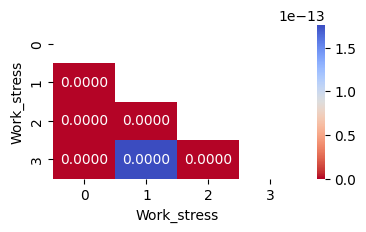

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


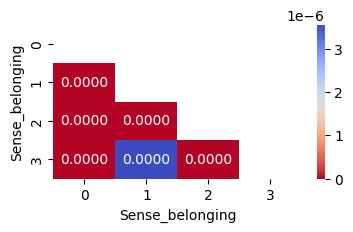

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


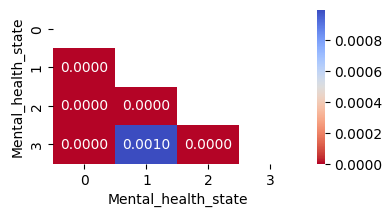

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


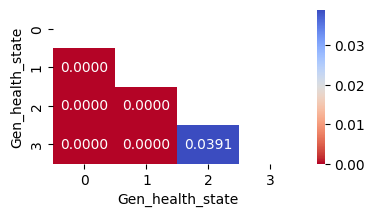

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


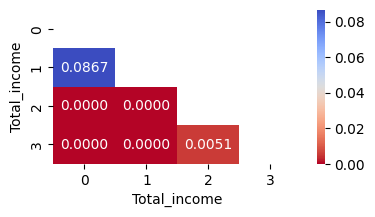

In [34]:
for feature in ['Work_stress', 'Sense_belonging', 'Mental_health_state', 'Gen_health_state', 'Total_income']:
    groups = sorted(data[feature].dropna().unique())
    Series = {i: data[data[feature] == i]['Stress_level'].dropna() for i in groups}
    
    p_matrix = pd.DataFrame(index=groups, columns=groups, dtype=float)
    
    for i in groups:
        for j in groups:
            if i == j:
                p_matrix.loc[i, j] = np.nan
            else:
                t_stat, p_val = ttest_ind(Series[i], Series[j], nan_policy='omit', equal_var=False)
                p_matrix.loc[i, j] = p_val
    
    plt.figure(figsize=(4, 2))
    sns.heatmap(p_matrix.astype(float), annot=True, fmt=".4f", cmap='coolwarm_r', mask=np.triu(np.ones_like(p_matrix, dtype=bool)))
    plt.xlabel(f'{feature}')
    plt.ylabel(f'{feature}')
    plt.show()

вот так лучше

In [35]:
cnt = 0
f = {}
drops = []
for feature in data.columns:
    result = []    
    groups = sorted(data[feature].dropna().unique())
    Series = {i: data[data[feature] == i]['Stress_level'].dropna() for i in groups}
    
    p_matrix = pd.DataFrame(index=groups, columns=groups, dtype=float)
    
    for i in groups:
        for j in groups:
            if i == j:
                p_matrix.loc[i, j] = np.nan
            else:
                t_stat, p_val = ttest_ind(Series[i], Series[j], nan_policy='omit', equal_var=False)
                p_matrix.loc[i, j] = p_val
                result.append(p_val)
                
    # lower_triangle = p_matrix.where(np.tril(np.ones(p_matrix.shape), k=-1).astype(bool))
    # mean_p = lower_triangle.stack().mean()

    
    mp =  np.mean(result)
    if mp < 0.01:    
        print(feature, f'{mp:.4f}')
        if feature in top:
            cnt+=1
            f[feature] = mp
    else: 
        f[feature] = mp+100
        drops.append(feature)

for x in top:
    print(x, f' = {f[x]:.6f}')
    

Gender 0.0000
Household 0.0000
Age 0.0000
Edu_level 0.0001
Gen_health_state 0.0065
Life_satisfaction 0.0001
Mental_health_state 0.0002


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Stress_level 0.0000
Work_stress 0.0000
Sense_belonging 0.0000
High_BP 0.0003
Diabetic 0.0000
Respiratory_chronic_con 0.0000
Musculoskeletal_con 0.0004
Cardiovascular_con 0.0000
Pain_status 0.0003
Act_improve_health 0.0062
Smoked 0.0031
weekly_alcohol 0.0022
Cannabies_use 0.0000
Physical_vigorous_act_time 0.0000
Work_hours 0.0088
Food_security 0.0019
Income_source 0.0000
Work_stress  = 0.000000
Life_satisfaction  = 0.000070
Mental_health_state  = 0.000167
Sense_belonging  = 0.000001
Age  = 0.000000
Gen_health_state  = 0.006521
Province  = 100.051599
Income_source  = 0.000000
Work_hours  = 0.008799
Edu_level  = 0.000121
Health_utility_indx  = 100.078846
Anxiety_disorder  = 100.103520
Food_security  = 0.001900
Total_income  = 100.015313
Gender  = 0.000000


In [36]:
data_sorted = data.drop(columns=drops)
data_sorted

,Gender,Household,Age,Edu_level,Gen_health_state,Life_satisfaction,Mental_health_state,Stress_level,Work_stress,Sense_belonging,High_BP,Diabetic,Respiratory_chronic_con,Musculoskeletal_con,Cardiovascular_con,Pain_status,Act_improve_health,Smoked,weekly_alcohol,Cannabies_use,Physical_vigorous_act_time,Work_hours,Food_security,Income_source
0,2,2,3,3,1,4,1,2,0,0,0,0,0,0,0,0,2,2,2,0,0,2,0,1
1,1,2,5,2,1,1,1,3,2,1,1,0,0,0,0,1,2,2,2,0,0,4,0,2
2,2,1,5,1,0,3,1,3,2,0,1,1,1,1,0,1,2,2,2,0,2,4,6,2
3,1,1,5,1,1,3,1,3,2,0,1,0,0,1,0,1,2,2,2,0,2,4,0,2
4,1,1,4,3,2,0,2,4,2,1,1,2,2,1,2,0,2,2,2,0,2,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108247,2,2,5,1,0,4,0,2,2,1,1,0,0,1,0,1,0,0,2,0,0,4,0,2
108248,2,2,2,3,1,2,2,4,0,0,0,0,0,0,0,1,2,2,1,1,2,1,1,1
108249,1,2,2,3,0,4,1,3,1,0,0,0,0,0,0,1,2,2,2,1,2,4,0,9
108250,1,2,5,2,1,3,0,2,2,0,0,0,0,0,0,1,2,2,2,0,2,4,6,2


# Лес🌲🌲🌲🌲🌲🌲🌲🌲

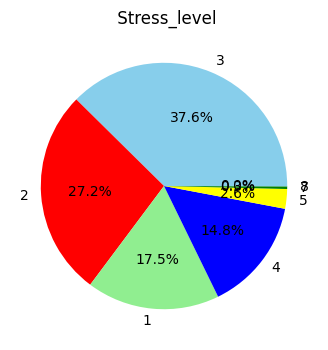

Stress_level
3    40668
2    29387
1    18877
4    16002
5     2786
7      375
8       47
Name: count, dtype: int64


In [37]:
class_counts = pd.Series(data['Stress_level']).value_counts()
plt.figure(figsize=(4, 4))
plt.title(f' Stress_level')
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=['skyblue', 'red', 'lightgreen', 'blue', 'yellow', 'green'])
plt.show()

print(class_counts)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


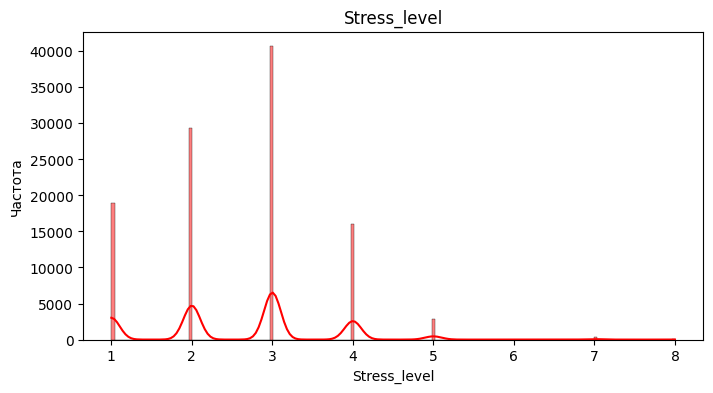

In [39]:
for column in ['Stress_level']:
    plt.figure(figsize=(8, 4))
    sns.histplot(data_sorted[column], kde=True, color='red')
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

не думаю, что 7 и 8 нам сильно нужны, лучше заменим на 5

In [40]:
# data_sorted['Stress_level'] = data_sorted['Stress_level'].replace(1, 0)
# data_sorted['Stress_level'] = data_sorted['Stress_level'].replace(2, 1)
# data_sorted['Stress_level'] = data_sorted['Stress_level'].replace(3, 2)
# data_sorted['Stress_level'] = data_sorted['Stress_level'].replace(4, 3)
# data_sorted['Stress_level'] = data_sorted['Stress_level'].replace([5,7,8], 4)
# data_sorted = data_sorted[data_sorted['Stress_level'] < 4] 

data_sorted['Stress_level'] = data_sorted['Stress_level'].replace([1, 2], 0)
data_sorted['Stress_level'] = data_sorted['Stress_level'].replace([3], 1)
data_sorted['Stress_level'] = data_sorted['Stress_level'].replace([4, 5, 7, 8], 2)
data_sorted.shape

(108142, 24)

In [41]:
X = data_sorted.drop('Stress_level', axis=1)
y = data_sorted['Stress_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.78      0.70      9585
           1       0.55      0.47      0.50      8212
           2       0.59      0.44      0.50      3832

    accuracy                           0.60     21629
   macro avg       0.59      0.56      0.57     21629
weighted avg       0.59      0.60      0.59     21629



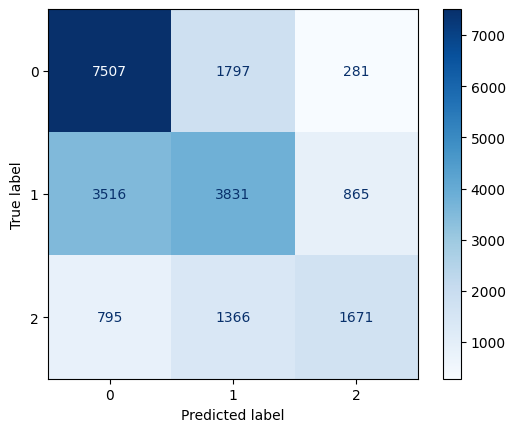

In [43]:
cm = confusion_matrix(y_test, y_pred)  # Матрица ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # Визуализация
plt.show()

In [44]:
data_sorted['predict'] = model.predict(data_sorted.drop('Stress_level', axis=1))
data_sorted

,Gender,Household,Age,Edu_level,Gen_health_state,Life_satisfaction,Mental_health_state,Stress_level,Work_stress,Sense_belonging,High_BP,Diabetic,Respiratory_chronic_con,Musculoskeletal_con,Cardiovascular_con,Pain_status,Act_improve_health,Smoked,weekly_alcohol,Cannabies_use,Physical_vigorous_act_time,Work_hours,Food_security,Income_source,predict
0,2,2,3,3,1,4,1,0,0,0,0,0,0,0,0,0,2,2,2,0,0,2,0,1,0
1,1,2,5,2,1,1,1,1,2,1,1,0,0,0,0,1,2,2,2,0,0,4,0,2,1
2,2,1,5,1,0,3,1,1,2,0,1,1,1,1,0,1,2,2,2,0,2,4,6,2,1
3,1,1,5,1,1,3,1,1,2,0,1,0,0,1,0,1,2,2,2,0,2,4,0,2,0
4,1,1,4,3,2,0,2,2,2,1,1,2,2,1,2,0,2,2,2,0,2,4,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108247,2,2,5,1,0,4,0,0,2,1,1,0,0,1,0,1,0,0,2,0,0,4,0,2,0
108248,2,2,2,3,1,2,2,2,0,0,0,0,0,0,0,1,2,2,1,1,2,1,1,1,2
108249,1,2,2,3,0,4,1,1,1,0,0,0,0,0,0,1,2,2,2,1,2,4,0,9,1
108250,1,2,5,2,1,3,0,0,2,0,0,0,0,0,0,1,2,2,2,0,2,4,6,2,0


In [57]:
df = data_sorted.copy()
df = pd.get_dummies(df, columns=df.drop('Stress_level', axis=1).columns)
df = df.astype(int)
df

,Stress_level,Gender_1,Gender_2,Household_1,Household_2,Household_9,Age_1,Age_2,Age_3,Age_4,Age_5,Edu_level_1,Edu_level_2,Edu_level_3,Edu_level_9,Gen_health_state_0,Gen_health_state_1,Gen_health_state_2,Gen_health_state_3,Life_satisfaction_0,Life_satisfaction_1,Life_satisfaction_2,Life_satisfaction_3,Life_satisfaction_4,Life_satisfaction_5,Mental_health_state_0,Mental_health_state_1,Mental_health_state_2,Mental_health_state_3,Work_stress_0,Work_stress_1,Work_stress_2,Work_stress_3,Sense_belonging_0,Sense_belonging_1,Sense_belonging_2,Sense_belonging_3,High_BP_0,High_BP_1,High_BP_2,Diabetic_0,Diabetic_1,Diabetic_2,Respiratory_chronic_con_0,Respiratory_chronic_con_1,Respiratory_chronic_con_2,Musculoskeletal_con_0,Musculoskeletal_con_1,Musculoskeletal_con_2,Cardiovascular_con_0,Cardiovascular_con_1,Cardiovascular_con_2,Pain_status_0,Pain_status_1,Pain_status_2,Act_improve_health_0,Act_improve_health_1,Act_improve_health_2,Smoked_0,Smoked_1,Smoked_2,weekly_alcohol_0,weekly_alcohol_1,weekly_alcohol_2,Cannabies_use_0,Cannabies_use_1,Cannabies_use_2,Physical_vigorous_act_time_0,Physical_vigorous_act_time_1,Physical_vigorous_act_time_2,Work_hours_0,Work_hours_1,Work_hours_2,Work_hours_3,Work_hours_4,Food_security_0,Food_security_1,Food_security_2,Food_security_3,Food_security_6,Food_security_9,Income_source_1,Income_source_2,Income_source_9,predict_0,predict_1,predict_2
0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0
1,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0
2,1,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
3,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0
4,2,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108247,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0
108248,2,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
108249,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0
108250,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0


# Перцепторн 🤔

In [58]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn.functional as F
from tqdm import tqdm

Customig dataset

In [60]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.X = torch.tensor(dataframe.drop('Stress_level', axis=1).values, dtype=torch.float32)
        self.y = torch.tensor(dataframe['Stress_level'].values, dtype=torch.long) # long -  для классификации
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [61]:
# Разделение данных
train_df, test_df0 = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)
val_df, test_df = train_test_split(test_df0, test_size=0.5, random_state=42, shuffle=True)

# Создание датасетов и загрузчиков
train_dataset = CustomDataset(train_df)
test_dataset = CustomDataset(test_df)
val_dataset = CustomDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset,  batch_size=16, shuffle=False)

In [62]:
class FourLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size):
        super().__init__()
        # Определяем слои
        self.fc0 = nn.LazyBatchNorm1d(input_size) # ленивый слой для нормализации
        self.fc1 = nn.Linear(input_size, hidden_size1)  # Первый скрытый слой
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)  # Второй скрытый слой
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)  # Третий скрытый слой
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)  # Четвертый скрытый слой
        self.fc5 = nn.Linear(hidden_size4, output_size)  # Выходной слой

    def forward(self, x):
        # Проход через сеть с активацией ReLU
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))  # Активация после первого слоя
        x = F.relu(self.fc2(x))  # Активация после второго слоя
        x = F.relu(self.fc3(x))  # Активация после третьего слоя
        x = F.relu(self.fc4(x))  # Активация после четвертого слоя
        x = self.fc5(x)  # Выходной слой (без активации)
        return x

    def fit(self, dataloader, epochs, learning_rate):
        # dataloader — генератор батчей из данных
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate) # оптимизатор для обновления весов модели
        criterion = nn.CrossEntropyLoss() # функция потерь

        self.train()
        for epoch in range(epochs):
            total_loss = 0
            for batch_X, batch_y in (bar:=tqdm(dataloader)): #tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
                # batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                optimizer.zero_grad() # обнуляем прошлые градиенты
                outputs = self(batch_X) # предсказания модели, вызывается forward, активация слоёв
                loss = criterion(outputs, batch_y) # подсчёт ошибки
                loss.backward() # вычисляет градиенты ошибки по всем параметрам сети 
                optimizer.step() # чтобы обновить веса модели в сторону уменьшения ошибки

                total_loss += loss.item()
            
            # валидация    
            preds_logits = [] 
            targets = [] 
            
            with torch.no_grad(): 
                for batch_X, batch_y in val_loader: 
                    outputs = perceptron(batch_X) # outputs — это logits (не softmax), т.е. "сырые оценки" уверенности по каждому классу
                    prediction = [list(logit) for logit in outputs]  # 
                    preds_logits.extend(list(prediction))
                    targets.extend(list(batch_y))

            # print(preds_logits, targets)
                    
            val_loss = criterion(torch.Tensor(preds_logits), torch.LongTensor(targets))

            # bar.set_description(f'epoch {epoch+1} loss: {total_loss}')                

            print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f} val loss: {val_loss}")

запустим обучение

In [64]:
input_size = df.drop('Stress_level', axis=1).shape[1]
# perceptron = ThreeLayerPerceptron(input_size, 256, 64, 32, 16, output_size=4)
perceptron = FourLayerPerceptron(input_size, 256, 64, 32, 16, output_size=3)
perceptron.fit(train_loader, 200, 0.001)

100%|██████████| 4732/4732 [00:13<00:00, 348.84it/s]


Epoch 1, Loss: 0.7055 val loss: 0.9558777809143066


100%|██████████| 4732/4732 [00:14<00:00, 332.43it/s]


Epoch 2, Loss: 0.6651 val loss: 0.9478853940963745


100%|██████████| 4732/4732 [00:14<00:00, 325.35it/s]


Epoch 3, Loss: 0.6561 val loss: 1.020132064819336


100%|██████████| 4732/4732 [00:14<00:00, 323.41it/s]


Epoch 4, Loss: 0.6512 val loss: 1.0489875078201294


100%|██████████| 4732/4732 [00:14<00:00, 321.27it/s]


Epoch 5, Loss: 0.6466 val loss: 0.982321560382843


100%|██████████| 4732/4732 [00:14<00:00, 322.59it/s]


Epoch 6, Loss: 0.6432 val loss: 1.0725730657577515


100%|██████████| 4732/4732 [00:14<00:00, 320.10it/s]


Epoch 7, Loss: 0.6402 val loss: 1.1552207469940186


100%|██████████| 4732/4732 [00:15<00:00, 311.30it/s]


Epoch 8, Loss: 0.6384 val loss: 1.0525668859481812


100%|██████████| 4732/4732 [00:15<00:00, 310.95it/s]


Epoch 9, Loss: 0.6355 val loss: 1.1302903890609741


100%|██████████| 4732/4732 [00:15<00:00, 298.73it/s]


Epoch 10, Loss: 0.6335 val loss: 1.0460703372955322


100%|██████████| 4732/4732 [00:15<00:00, 305.65it/s]


Epoch 11, Loss: 0.6310 val loss: 1.187408685684204


100%|██████████| 4732/4732 [00:16<00:00, 292.87it/s]


Epoch 12, Loss: 0.6294 val loss: 1.1141729354858398


100%|██████████| 4732/4732 [00:16<00:00, 287.29it/s]


Epoch 13, Loss: 0.6267 val loss: 1.1854759454727173


100%|██████████| 4732/4732 [00:16<00:00, 282.52it/s]


Epoch 14, Loss: 0.6252 val loss: 1.1338410377502441


100%|██████████| 4732/4732 [00:17<00:00, 265.91it/s]


Epoch 15, Loss: 0.6231 val loss: 1.2225673198699951


100%|██████████| 4732/4732 [00:17<00:00, 268.71it/s]


Epoch 16, Loss: 0.6209 val loss: 1.2812740802764893


100%|██████████| 4732/4732 [00:17<00:00, 263.94it/s]


Epoch 17, Loss: 0.6190 val loss: 1.2104243040084839


100%|██████████| 4732/4732 [00:17<00:00, 264.99it/s]


Epoch 18, Loss: 0.6175 val loss: 1.2849044799804688


100%|██████████| 4732/4732 [00:18<00:00, 261.18it/s]


Epoch 19, Loss: 0.6146 val loss: 1.2532868385314941


100%|██████████| 4732/4732 [00:17<00:00, 265.49it/s]


Epoch 20, Loss: 0.6128 val loss: 1.430310606956482


100%|██████████| 4732/4732 [00:18<00:00, 260.54it/s]


Epoch 21, Loss: 0.6111 val loss: 1.3571213483810425


100%|██████████| 4732/4732 [00:18<00:00, 261.05it/s]


Epoch 22, Loss: 0.6088 val loss: 1.3690317869186401


100%|██████████| 4732/4732 [00:17<00:00, 268.72it/s]


Epoch 23, Loss: 0.6073 val loss: 1.3395518064498901


100%|██████████| 4732/4732 [00:18<00:00, 260.16it/s]


Epoch 24, Loss: 0.6044 val loss: 1.6119283437728882


100%|██████████| 4732/4732 [00:18<00:00, 262.68it/s]


Epoch 25, Loss: 0.6035 val loss: 1.3370511531829834


100%|██████████| 4732/4732 [00:18<00:00, 258.43it/s]


Epoch 26, Loss: 0.6011 val loss: 1.5362950563430786


100%|██████████| 4732/4732 [00:17<00:00, 265.40it/s]


Epoch 27, Loss: 0.5989 val loss: 1.661125898361206


100%|██████████| 4732/4732 [00:17<00:00, 268.08it/s]


Epoch 28, Loss: 0.5968 val loss: 1.4642845392227173


100%|██████████| 4732/4732 [00:17<00:00, 266.95it/s]


Epoch 29, Loss: 0.5947 val loss: 1.438789963722229


100%|██████████| 4732/4732 [00:17<00:00, 268.68it/s]


Epoch 30, Loss: 0.5925 val loss: 1.6676992177963257


100%|██████████| 4732/4732 [00:18<00:00, 261.78it/s]


Epoch 31, Loss: 0.5910 val loss: 1.4371544122695923


100%|██████████| 4732/4732 [00:17<00:00, 267.32it/s]


Epoch 32, Loss: 0.5884 val loss: 1.6127396821975708


100%|██████████| 4732/4732 [00:17<00:00, 266.99it/s]


Epoch 33, Loss: 0.5863 val loss: 1.7842180728912354


100%|██████████| 4732/4732 [00:17<00:00, 264.87it/s]


Epoch 34, Loss: 0.5843 val loss: 1.6334549188613892


100%|██████████| 4732/4732 [00:17<00:00, 263.67it/s]


Epoch 35, Loss: 0.5824 val loss: 1.712291955947876


100%|██████████| 4732/4732 [00:18<00:00, 260.72it/s]


Epoch 36, Loss: 0.5804 val loss: 1.800018548965454


100%|██████████| 4732/4732 [00:17<00:00, 267.03it/s]


Epoch 37, Loss: 0.5790 val loss: 1.7697633504867554


100%|██████████| 4732/4732 [00:18<00:00, 255.36it/s]


Epoch 38, Loss: 0.5762 val loss: 2.0153605937957764


100%|██████████| 4732/4732 [00:17<00:00, 266.24it/s]


Epoch 39, Loss: 0.5759 val loss: 1.864025354385376


100%|██████████| 4732/4732 [00:18<00:00, 258.70it/s]


Epoch 40, Loss: 0.5733 val loss: 1.8035212755203247


100%|██████████| 4732/4732 [00:18<00:00, 255.53it/s]


Epoch 41, Loss: 0.5707 val loss: 1.911574125289917


100%|██████████| 4732/4732 [00:17<00:00, 268.98it/s]


Epoch 42, Loss: 0.5702 val loss: 1.9838711023330688


100%|██████████| 4732/4732 [00:18<00:00, 262.80it/s]


Epoch 43, Loss: 0.5692 val loss: 2.00219464302063


100%|██████████| 4732/4732 [00:17<00:00, 266.26it/s]


Epoch 44, Loss: 0.5668 val loss: 1.8777934312820435


100%|██████████| 4732/4732 [00:18<00:00, 262.07it/s]


Epoch 45, Loss: 0.5645 val loss: 2.248976945877075


100%|██████████| 4732/4732 [00:17<00:00, 266.52it/s]


Epoch 46, Loss: 0.5618 val loss: 2.0887436866760254


100%|██████████| 4732/4732 [00:17<00:00, 275.11it/s]


Epoch 47, Loss: 0.5614 val loss: 2.0063703060150146


100%|██████████| 4732/4732 [00:17<00:00, 272.41it/s]


Epoch 48, Loss: 0.5593 val loss: 2.0658421516418457


100%|██████████| 4732/4732 [00:17<00:00, 278.24it/s]


Epoch 49, Loss: 0.5570 val loss: 2.1232988834381104


100%|██████████| 4732/4732 [00:17<00:00, 274.04it/s]


Epoch 50, Loss: 0.5566 val loss: 2.0694921016693115


100%|██████████| 4732/4732 [00:17<00:00, 274.02it/s]


Epoch 51, Loss: 0.5523 val loss: 2.062915563583374


100%|██████████| 4732/4732 [00:17<00:00, 271.80it/s]


Epoch 52, Loss: 0.5508 val loss: 2.391364336013794


100%|██████████| 4732/4732 [00:17<00:00, 271.12it/s]


Epoch 53, Loss: 0.5511 val loss: 2.246459484100342


100%|██████████| 4732/4732 [00:17<00:00, 266.61it/s]


Epoch 54, Loss: 0.5481 val loss: 2.171034574508667


100%|██████████| 4732/4732 [00:17<00:00, 268.39it/s]


Epoch 55, Loss: 0.5492 val loss: 2.3072633743286133


100%|██████████| 4732/4732 [00:17<00:00, 273.08it/s]


Epoch 56, Loss: 0.5463 val loss: 2.2001283168792725


100%|██████████| 4732/4732 [00:18<00:00, 261.29it/s]


Epoch 57, Loss: 0.5447 val loss: 2.23738431930542


100%|██████████| 4732/4732 [00:17<00:00, 272.82it/s]


Epoch 58, Loss: 0.5441 val loss: 2.422499895095825


100%|██████████| 4732/4732 [00:17<00:00, 269.48it/s]


Epoch 59, Loss: 0.5412 val loss: 2.45710825920105


100%|██████████| 4732/4732 [00:17<00:00, 271.05it/s]


Epoch 60, Loss: 0.5401 val loss: 2.5939407348632812


100%|██████████| 4732/4732 [00:17<00:00, 269.37it/s]


Epoch 61, Loss: 0.5380 val loss: 2.37630295753479


100%|██████████| 4732/4732 [00:17<00:00, 269.49it/s]


Epoch 62, Loss: 0.5379 val loss: 2.644831895828247


100%|██████████| 4732/4732 [00:17<00:00, 274.66it/s]


Epoch 63, Loss: 0.5352 val loss: 2.3531131744384766


100%|██████████| 4732/4732 [00:17<00:00, 268.05it/s]


Epoch 64, Loss: 0.5338 val loss: 2.5078511238098145


100%|██████████| 4732/4732 [00:17<00:00, 274.45it/s]


Epoch 65, Loss: 0.5324 val loss: 2.603379487991333


100%|██████████| 4732/4732 [00:17<00:00, 271.34it/s]


Epoch 66, Loss: 0.5321 val loss: 2.5652036666870117


100%|██████████| 4732/4732 [00:17<00:00, 270.06it/s]


Epoch 67, Loss: 0.5303 val loss: 2.6361911296844482


100%|██████████| 4732/4732 [00:17<00:00, 268.06it/s]


Epoch 68, Loss: 0.5279 val loss: 2.372077465057373


100%|██████████| 4732/4732 [00:17<00:00, 263.82it/s]


Epoch 69, Loss: 0.5299 val loss: 2.6801395416259766


100%|██████████| 4732/4732 [00:17<00:00, 269.70it/s]


Epoch 70, Loss: 0.5242 val loss: 2.790769338607788


100%|██████████| 4732/4732 [00:17<00:00, 273.09it/s]


Epoch 71, Loss: 0.5244 val loss: 2.647189140319824


100%|██████████| 4732/4732 [00:17<00:00, 274.48it/s]


Epoch 72, Loss: 0.5240 val loss: 2.696607828140259


100%|██████████| 4732/4732 [00:17<00:00, 272.59it/s]


Epoch 73, Loss: 0.5227 val loss: 2.5507733821868896


100%|██████████| 4732/4732 [00:17<00:00, 272.76it/s]


Epoch 74, Loss: 0.5210 val loss: 2.6755692958831787


100%|██████████| 4732/4732 [00:17<00:00, 269.57it/s]


Epoch 75, Loss: 0.5198 val loss: 2.6680376529693604


100%|██████████| 4732/4732 [00:17<00:00, 276.73it/s]


Epoch 76, Loss: 0.5171 val loss: 2.8273236751556396


100%|██████████| 4732/4732 [00:17<00:00, 271.81it/s]


Epoch 77, Loss: 0.5176 val loss: 2.547548532485962


100%|██████████| 4732/4732 [00:17<00:00, 271.43it/s]


Epoch 78, Loss: 0.5158 val loss: 2.516408920288086


100%|██████████| 4732/4732 [00:17<00:00, 276.39it/s]


Epoch 79, Loss: 0.5152 val loss: 2.72316837310791


100%|██████████| 4732/4732 [00:17<00:00, 270.06it/s]


Epoch 80, Loss: 0.5141 val loss: 2.6825666427612305


100%|██████████| 4732/4732 [00:17<00:00, 277.55it/s]


Epoch 81, Loss: 0.5145 val loss: 2.4760334491729736


100%|██████████| 4732/4732 [00:17<00:00, 270.95it/s]


Epoch 82, Loss: 0.5129 val loss: 2.6333374977111816


100%|██████████| 4732/4732 [00:17<00:00, 273.68it/s]


Epoch 83, Loss: 0.5103 val loss: 2.704613447189331


100%|██████████| 4732/4732 [00:17<00:00, 266.55it/s]


Epoch 84, Loss: 0.5101 val loss: 2.794283151626587


100%|██████████| 4732/4732 [00:17<00:00, 274.13it/s]


Epoch 85, Loss: 0.5081 val loss: 2.897465705871582


100%|██████████| 4732/4732 [00:17<00:00, 277.83it/s]


Epoch 86, Loss: 0.5082 val loss: 3.0703418254852295


100%|██████████| 4732/4732 [00:17<00:00, 267.00it/s]


Epoch 87, Loss: 0.5059 val loss: 2.8981122970581055


100%|██████████| 4732/4732 [00:17<00:00, 276.42it/s]


Epoch 88, Loss: 0.5053 val loss: 2.95806884765625


100%|██████████| 4732/4732 [00:17<00:00, 273.26it/s]


Epoch 89, Loss: 0.5037 val loss: 2.8480224609375


100%|██████████| 4732/4732 [00:17<00:00, 274.51it/s]


Epoch 90, Loss: 0.5020 val loss: 3.0662477016448975


100%|██████████| 4732/4732 [00:17<00:00, 263.91it/s]


Epoch 91, Loss: 0.5037 val loss: 2.5987658500671387


100%|██████████| 4732/4732 [00:17<00:00, 276.13it/s]


Epoch 92, Loss: 0.5016 val loss: 2.9721317291259766


100%|██████████| 4732/4732 [00:17<00:00, 269.85it/s]


Epoch 93, Loss: 0.5001 val loss: 2.809326648712158


100%|██████████| 4732/4732 [00:17<00:00, 266.04it/s]


Epoch 94, Loss: 0.5000 val loss: 2.779876708984375


100%|██████████| 4732/4732 [00:17<00:00, 276.52it/s]


Epoch 95, Loss: 0.4970 val loss: 2.9785053730010986


100%|██████████| 4732/4732 [00:17<00:00, 271.64it/s]


Epoch 96, Loss: 0.4964 val loss: 3.114267349243164


100%|██████████| 4732/4732 [00:17<00:00, 273.92it/s]


Epoch 97, Loss: 0.4956 val loss: 2.850698471069336


100%|██████████| 4732/4732 [00:17<00:00, 270.44it/s]


Epoch 98, Loss: 0.4968 val loss: 2.899775266647339


100%|██████████| 4732/4732 [00:17<00:00, 272.74it/s]


Epoch 99, Loss: 0.4932 val loss: 3.0017294883728027


100%|██████████| 4732/4732 [00:17<00:00, 269.83it/s]


Epoch 100, Loss: 0.4933 val loss: 2.8192226886749268


100%|██████████| 4732/4732 [00:17<00:00, 274.44it/s]


Epoch 101, Loss: 0.4908 val loss: 2.9024124145507812


100%|██████████| 4732/4732 [00:16<00:00, 279.30it/s]


Epoch 102, Loss: 0.4895 val loss: 2.892124891281128


100%|██████████| 4732/4732 [00:17<00:00, 268.18it/s]


Epoch 103, Loss: 0.4916 val loss: 2.8235936164855957


100%|██████████| 4732/4732 [00:17<00:00, 277.35it/s]


Epoch 104, Loss: 0.4886 val loss: 2.8064284324645996


100%|██████████| 4732/4732 [00:17<00:00, 274.79it/s]


Epoch 105, Loss: 0.4896 val loss: 3.120110034942627


100%|██████████| 4732/4732 [00:17<00:00, 277.62it/s]


Epoch 106, Loss: 0.4892 val loss: 3.032209634780884


100%|██████████| 4732/4732 [00:17<00:00, 270.74it/s]


Epoch 107, Loss: 0.4856 val loss: 3.1770260334014893


100%|██████████| 4732/4732 [00:16<00:00, 279.33it/s]


Epoch 108, Loss: 0.4857 val loss: 2.9025399684906006


100%|██████████| 4732/4732 [00:17<00:00, 269.80it/s]


Epoch 109, Loss: 0.4865 val loss: 3.1683413982391357


100%|██████████| 4732/4732 [00:17<00:00, 270.88it/s]


Epoch 110, Loss: 0.4854 val loss: 2.8725578784942627


100%|██████████| 4732/4732 [00:17<00:00, 277.58it/s]


Epoch 111, Loss: 0.4844 val loss: 2.862861156463623


100%|██████████| 4732/4732 [00:17<00:00, 269.99it/s]


Epoch 112, Loss: 0.4835 val loss: 3.0031020641326904


100%|██████████| 4732/4732 [00:17<00:00, 275.46it/s]


Epoch 113, Loss: 0.4826 val loss: 3.1879377365112305


100%|██████████| 4732/4732 [00:17<00:00, 272.32it/s]


Epoch 114, Loss: 0.4796 val loss: 3.2034573554992676


100%|██████████| 4732/4732 [00:17<00:00, 274.11it/s]


Epoch 115, Loss: 0.4805 val loss: 3.0265448093414307


100%|██████████| 4732/4732 [00:17<00:00, 267.15it/s]


Epoch 116, Loss: 0.4782 val loss: 2.9775428771972656


100%|██████████| 4732/4732 [00:17<00:00, 271.63it/s]


Epoch 117, Loss: 0.4796 val loss: 3.0905845165252686


100%|██████████| 4732/4732 [00:17<00:00, 269.70it/s]


Epoch 118, Loss: 0.4779 val loss: 3.1908371448516846


100%|██████████| 4732/4732 [00:17<00:00, 271.58it/s]


Epoch 119, Loss: 0.4773 val loss: 2.9587481021881104


100%|██████████| 4732/4732 [00:17<00:00, 277.02it/s]


Epoch 120, Loss: 0.4778 val loss: 3.084778070449829


100%|██████████| 4732/4732 [00:17<00:00, 272.07it/s]


Epoch 121, Loss: 0.4774 val loss: 2.969599962234497


100%|██████████| 4732/4732 [00:17<00:00, 275.16it/s]


Epoch 122, Loss: 0.4740 val loss: 3.1929731369018555


100%|██████████| 4732/4732 [00:17<00:00, 274.21it/s]


Epoch 123, Loss: 0.4746 val loss: 3.1776223182678223


100%|██████████| 4732/4732 [00:17<00:00, 276.04it/s]


Epoch 124, Loss: 0.4742 val loss: 3.181311845779419


100%|██████████| 4732/4732 [00:17<00:00, 276.37it/s]


Epoch 125, Loss: 0.4734 val loss: 3.1758780479431152


100%|██████████| 4732/4732 [00:17<00:00, 277.96it/s]


Epoch 126, Loss: 0.4741 val loss: 2.866981029510498


100%|██████████| 4732/4732 [00:17<00:00, 277.09it/s]


Epoch 127, Loss: 0.4721 val loss: 3.412885904312134


100%|██████████| 4732/4732 [00:17<00:00, 272.01it/s]


Epoch 128, Loss: 0.4697 val loss: 3.3132450580596924


100%|██████████| 4732/4732 [00:17<00:00, 275.72it/s]


Epoch 129, Loss: 0.4727 val loss: 3.1436238288879395


100%|██████████| 4732/4732 [00:17<00:00, 267.59it/s]


Epoch 130, Loss: 0.4709 val loss: 3.3122522830963135


100%|██████████| 4732/4732 [00:17<00:00, 278.06it/s]


Epoch 131, Loss: 0.4705 val loss: 3.003566265106201


100%|██████████| 4732/4732 [00:17<00:00, 268.76it/s]


Epoch 132, Loss: 0.4719 val loss: 3.2294366359710693


100%|██████████| 4732/4732 [00:17<00:00, 273.22it/s]


Epoch 133, Loss: 0.4665 val loss: 3.1080591678619385


100%|██████████| 4732/4732 [00:17<00:00, 271.01it/s]


Epoch 134, Loss: 0.4683 val loss: 3.187380313873291


100%|██████████| 4732/4732 [00:17<00:00, 267.96it/s]


Epoch 135, Loss: 0.4677 val loss: 3.0844500064849854


100%|██████████| 4732/4732 [00:17<00:00, 276.74it/s]


Epoch 136, Loss: 0.4658 val loss: 3.2266910076141357


100%|██████████| 4732/4732 [00:17<00:00, 264.83it/s]


Epoch 137, Loss: 0.4637 val loss: 3.4498958587646484


100%|██████████| 4732/4732 [00:17<00:00, 274.08it/s]


Epoch 138, Loss: 0.4667 val loss: 3.3735766410827637


100%|██████████| 4732/4732 [00:17<00:00, 271.40it/s]


Epoch 139, Loss: 0.4651 val loss: 3.069622755050659


100%|██████████| 4732/4732 [00:17<00:00, 277.71it/s]


Epoch 140, Loss: 0.4649 val loss: 3.517462730407715


100%|██████████| 4732/4732 [00:17<00:00, 272.09it/s]


Epoch 141, Loss: 0.4641 val loss: 3.462547779083252


100%|██████████| 4732/4732 [00:17<00:00, 276.14it/s]


Epoch 142, Loss: 0.4625 val loss: 3.424543857574463


100%|██████████| 4732/4732 [00:17<00:00, 271.26it/s]


Epoch 143, Loss: 0.4627 val loss: 3.8462114334106445


100%|██████████| 4732/4732 [00:17<00:00, 275.90it/s]


Epoch 144, Loss: 0.4619 val loss: 3.3345189094543457


100%|██████████| 4732/4732 [00:17<00:00, 275.93it/s]


Epoch 145, Loss: 0.4610 val loss: 3.422199249267578


100%|██████████| 4732/4732 [00:17<00:00, 271.93it/s]


Epoch 146, Loss: 0.4612 val loss: 3.221402168273926


100%|██████████| 4732/4732 [00:17<00:00, 277.94it/s]


Epoch 147, Loss: 0.4621 val loss: 3.4085655212402344


100%|██████████| 4732/4732 [00:17<00:00, 265.39it/s]


Epoch 148, Loss: 0.4588 val loss: 3.459099054336548


100%|██████████| 4732/4732 [00:17<00:00, 277.05it/s]


Epoch 149, Loss: 0.4605 val loss: 3.4448232650756836


100%|██████████| 4732/4732 [00:17<00:00, 270.32it/s]


Epoch 150, Loss: 0.4586 val loss: 3.4891064167022705


100%|██████████| 4732/4732 [00:17<00:00, 274.09it/s]


Epoch 151, Loss: 0.4595 val loss: 3.330857276916504


100%|██████████| 4732/4732 [00:17<00:00, 275.22it/s]


Epoch 152, Loss: 0.4588 val loss: 3.349140167236328


100%|██████████| 4732/4732 [00:17<00:00, 273.32it/s]


Epoch 153, Loss: 0.4580 val loss: 3.3383114337921143


100%|██████████| 4732/4732 [00:17<00:00, 276.79it/s]


Epoch 154, Loss: 0.4570 val loss: 3.5337536334991455


100%|██████████| 4732/4732 [00:17<00:00, 274.13it/s]


Epoch 155, Loss: 0.4576 val loss: 3.694305896759033


100%|██████████| 4732/4732 [00:16<00:00, 278.83it/s]


Epoch 156, Loss: 0.4576 val loss: 3.3451156616210938


100%|██████████| 4732/4732 [00:17<00:00, 270.77it/s]


Epoch 157, Loss: 0.4556 val loss: 3.560681104660034


100%|██████████| 4732/4732 [00:16<00:00, 280.42it/s]


Epoch 158, Loss: 0.4564 val loss: 3.4778411388397217


100%|██████████| 4732/4732 [00:17<00:00, 275.60it/s]


Epoch 159, Loss: 0.4567 val loss: 3.710476875305176


100%|██████████| 4732/4732 [00:17<00:00, 277.98it/s]


Epoch 160, Loss: 0.4553 val loss: 3.4880874156951904


100%|██████████| 4732/4732 [00:17<00:00, 278.22it/s]


Epoch 161, Loss: 0.4546 val loss: 3.6793859004974365


100%|██████████| 4732/4732 [00:17<00:00, 270.28it/s]


Epoch 162, Loss: 0.4535 val loss: 3.606959819793701


100%|██████████| 4732/4732 [00:17<00:00, 276.62it/s]


Epoch 163, Loss: 0.4546 val loss: 3.83188533782959


100%|██████████| 4732/4732 [00:17<00:00, 278.02it/s]


Epoch 164, Loss: 0.4526 val loss: 3.5042333602905273


100%|██████████| 4732/4732 [00:17<00:00, 277.99it/s]


Epoch 165, Loss: 0.4532 val loss: 3.551210403442383


100%|██████████| 4732/4732 [00:17<00:00, 275.48it/s]


Epoch 166, Loss: 0.4516 val loss: 3.5133769512176514


100%|██████████| 4732/4732 [00:17<00:00, 277.91it/s]


Epoch 167, Loss: 0.4523 val loss: 3.7559797763824463


100%|██████████| 4732/4732 [00:17<00:00, 268.69it/s]


Epoch 168, Loss: 0.4506 val loss: 3.7468032836914062


100%|██████████| 4732/4732 [00:17<00:00, 276.23it/s]


Epoch 169, Loss: 0.4519 val loss: 3.6590285301208496


100%|██████████| 4732/4732 [00:17<00:00, 273.96it/s]


Epoch 170, Loss: 0.4499 val loss: 3.7267186641693115


100%|██████████| 4732/4732 [00:17<00:00, 276.64it/s]


Epoch 171, Loss: 0.4525 val loss: 3.5892786979675293


100%|██████████| 4732/4732 [00:17<00:00, 278.18it/s]


Epoch 172, Loss: 0.4509 val loss: 3.5234124660491943


100%|██████████| 4732/4732 [00:17<00:00, 276.73it/s]


Epoch 173, Loss: 0.4491 val loss: 3.3742284774780273


100%|██████████| 4732/4732 [00:16<00:00, 281.76it/s]


Epoch 174, Loss: 0.4502 val loss: 3.6421916484832764


100%|██████████| 4732/4732 [00:17<00:00, 271.87it/s]


Epoch 175, Loss: 0.4479 val loss: 3.5776925086975098


100%|██████████| 4732/4732 [00:16<00:00, 281.27it/s]


Epoch 176, Loss: 0.4480 val loss: 3.7542877197265625


100%|██████████| 4732/4732 [00:17<00:00, 278.08it/s]


Epoch 177, Loss: 0.4479 val loss: 3.709808826446533


100%|██████████| 4732/4732 [00:16<00:00, 278.94it/s]


Epoch 178, Loss: 0.4458 val loss: 3.614161729812622


100%|██████████| 4732/4732 [00:17<00:00, 275.58it/s]


Epoch 179, Loss: 0.4474 val loss: 3.517712354660034


100%|██████████| 4732/4732 [00:17<00:00, 275.80it/s]


Epoch 180, Loss: 0.4466 val loss: 3.7134196758270264


100%|██████████| 4732/4732 [00:16<00:00, 279.10it/s]


Epoch 181, Loss: 0.4453 val loss: 3.5699939727783203


100%|██████████| 4732/4732 [00:17<00:00, 273.49it/s]


Epoch 182, Loss: 0.4455 val loss: 3.762566328048706


100%|██████████| 4732/4732 [00:17<00:00, 275.53it/s]


Epoch 183, Loss: 0.4453 val loss: 3.7296016216278076


100%|██████████| 4732/4732 [00:17<00:00, 269.06it/s]


Epoch 184, Loss: 0.4444 val loss: 3.5478403568267822


100%|██████████| 4732/4732 [00:17<00:00, 276.19it/s]


Epoch 185, Loss: 0.4464 val loss: 3.605905055999756


100%|██████████| 4732/4732 [00:17<00:00, 269.74it/s]


Epoch 186, Loss: 0.4453 val loss: 3.6561532020568848


100%|██████████| 4732/4732 [00:17<00:00, 276.10it/s]


Epoch 187, Loss: 0.4438 val loss: 3.768709182739258


100%|██████████| 4732/4732 [00:17<00:00, 275.21it/s]


Epoch 188, Loss: 0.4424 val loss: 3.7091705799102783


100%|██████████| 4732/4732 [00:17<00:00, 271.79it/s]


Epoch 189, Loss: 0.4455 val loss: 3.761054754257202


100%|██████████| 4732/4732 [00:16<00:00, 278.38it/s]


Epoch 190, Loss: 0.4448 val loss: 3.8377127647399902


100%|██████████| 4732/4732 [00:17<00:00, 276.10it/s]


Epoch 191, Loss: 0.4422 val loss: 3.848979949951172


100%|██████████| 4732/4732 [00:17<00:00, 275.96it/s]


Epoch 192, Loss: 0.4424 val loss: 3.8216400146484375


100%|██████████| 4732/4732 [00:17<00:00, 270.03it/s]


Epoch 193, Loss: 0.4419 val loss: 3.7645926475524902


100%|██████████| 4732/4732 [00:17<00:00, 272.16it/s]


Epoch 194, Loss: 0.4412 val loss: 3.7403600215911865


100%|██████████| 4732/4732 [00:17<00:00, 270.84it/s]


Epoch 195, Loss: 0.4396 val loss: 3.920414686203003


100%|██████████| 4732/4732 [00:17<00:00, 263.97it/s]


Epoch 196, Loss: 0.4414 val loss: 3.8997440338134766


100%|██████████| 4732/4732 [00:17<00:00, 274.75it/s]


Epoch 197, Loss: 0.4389 val loss: 4.002002239227295


100%|██████████| 4732/4732 [00:17<00:00, 269.19it/s]


Epoch 198, Loss: 0.4410 val loss: 3.9489595890045166


100%|██████████| 4732/4732 [00:17<00:00, 274.71it/s]


Epoch 199, Loss: 0.4405 val loss: 3.882387399673462


100%|██████████| 4732/4732 [00:17<00:00, 269.53it/s]


Epoch 200, Loss: 0.4417 val loss: 3.6632068157196045


оценка

In [65]:
perceptron.eval()  # переводим модель в режим оценки

preds = [] # предсказания
targets = [] # цель

with torch.no_grad():  # Я просто хочу сделать предсказания, не обучая модель
    for batch_X, batch_y in test_loader: 
        outputs = perceptron(batch_X) # outputs — это logits (не softmax), т.е. "сырые оценки" уверенности по каждому классу
        prediction = torch.argmax(outputs, dim=1)  # Из каждого логита выбираем наиболее вероятный класс
        preds.extend(prediction.numpy())
        targets.extend(batch_y.numpy())


In [69]:
print(classification_report(targets, preds))

              precision    recall  f1-score   support

           0       0.64      0.75      0.69      7158
           1       0.57      0.49      0.53      6163
           2       0.59      0.52      0.55      2901

    accuracy                           0.61     16222
   macro avg       0.60      0.59      0.59     16222
weighted avg       0.61      0.61      0.61     16222



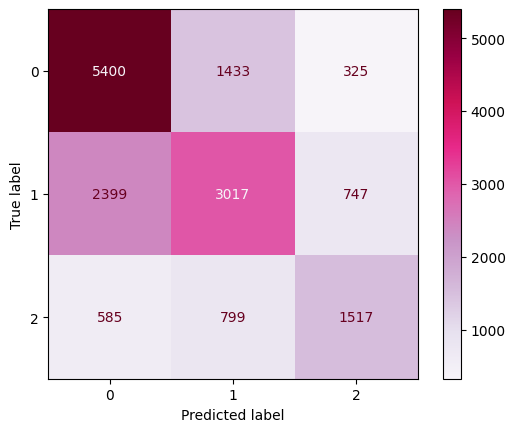

In [71]:
cm = confusion_matrix(targets, preds) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='PuRd')
plt.show()